# Data Wrangling Pet Datasets
Four pet adoption datasets were found on governmental and adoption websites representing Austin, TX, Louisville, KY, Dallas, TX, and Sonoma, CA. The dataset includes various species of animals and the prime focus of this study is to investigate the different adoption rates in these regions with the purpose of statistically understanding whether regions have preferences to the type of animals that are adopted. Ultimately, we would want to develop a machine learning model to predict the adoption likelihood of potential pets. This can ultimately allow users to effectively allocate resources to endangered animals and improve their chances of adoption. To limit the scope of the project, this would only focus on dog.
### Wrangling Approach:
The biggest challenge to the data wrangling portion of this project is to effectively merge the datasets. Since there is no universal standard in organizing and collecting data, these datasets were likely collected for the purpose of record keeping instead of data science purposes. Merging the datasets would results in abundance of missing data and important features. The data wrangling process will take a 2 step approach.
 1. Merge the datasets
         a. universalize the feature names 
         b. drop unimportant features
         c. if necessary feature engineer dataset
 2. Clean the merged dataset
         a. clean dataset
         b. feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import keras
from datetime import datetime as dt

Using TensorFlow backend.


In [2]:
# import datasets
df_Austin = pd.read_csv('Dataset/Austin_Animal_Center_Outcomes.csv', parse_dates = 
                        ['DateTime', 'MonthYear', 'Date of Birth'])
df_Louisville = pd.read_csv('Dataset/Louisville_Kentucky_Animal_IO_Data_5.csv', parse_dates = 
                            ['IntakeDate', 'DOB', 'OutcomeDate'])
df_Dallas = pd.read_csv('Dataset/Dallas_FY_2017_Dallas_Animal_Shelter_Data.csv', parse_dates = 
                        ['Intake Date', 'Outcome Date'])
df_Sonoma = pd.read_csv('Dataset/Sonoma_County_Animal_Shelter_Intake_and_Outcome.csv', parse_dates = 
                        ['Date Of Birth', 'Intake Date', 'Outcome Date'])

In [3]:
# start by investigating Austin, Texas Dataset
df_Austin.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A789976,NaN,2019-03-05 19:07:00,2019-03-05 19:07:00,2018-03-02,Transfer,Snr,Cat,Intact Male,1 year,Domestic Medium Hair Mix,Black
1,A789980,NaN,2019-03-05 19:07:00,2019-03-05 19:07:00,2018-03-02,Transfer,Snr,Cat,Intact Male,1 year,Domestic Shorthair Mix,Black/White
2,A789966,NaN,2019-03-05 19:06:00,2019-03-05 19:06:00,2018-03-02,Transfer,Snr,Cat,Unknown,1 year,Domestic Medium Hair Mix,Orange Tabby/White
3,A789958,NaN,2019-03-05 19:05:00,2019-03-05 19:05:00,2017-03-02,Transfer,Snr,Cat,Intact Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
4,A789838,*Tansy,2019-03-05 19:01:00,2019-03-05 19:01:00,2018-02-28,Adoption,NaN,Dog,Spayed Female,1 year,Golden Retriever Mix,Cream/White


In [4]:
df_Austin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96442 entries, 0 to 96441
Data columns (total 12 columns):
Animal ID           96442 non-null object
Name                66738 non-null object
DateTime            96442 non-null datetime64[ns]
MonthYear           96442 non-null datetime64[ns]
Date of Birth       96442 non-null datetime64[ns]
Outcome Type        96435 non-null object
Outcome Subtype     43686 non-null object
Animal Type         96442 non-null object
Sex upon Outcome    96440 non-null object
Age upon Outcome    96436 non-null object
Breed               96442 non-null object
Color               96442 non-null object
dtypes: datetime64[ns](3), object(9)
memory usage: 8.8+ MB


In [5]:
#check redundancy of 'DateTime' and 'MonthYear' columns
(df_Austin.loc[:, 'DateTime'] == df_Austin.loc[:, 'MonthYear']).all()

True

In [6]:
# drop features unrelated to analysis and add location feature for merging dataset
df_Austin = df_Austin.drop(columns = ['Animal ID','Name', 'MonthYear', 'Age upon Outcome'])
df_Austin['Location'] = 'Austin'

In [7]:
#Rename Columns and resulting dataframe
df_Austin.columns = ['Outcome_Date', 'DOB', 'Outcome_Type', 'Outcome_Subtype', 'Animal_Type',
                    'Sex', 'Breed', 'Color', 'Location']
df_Austin.head()

,Outcome_Date,DOB,Outcome_Type,Outcome_Subtype,Animal_Type,Sex,Breed,Color,Location
0,2019-03-05 19:07:00,2018-03-02,Transfer,Snr,Cat,Intact Male,Domestic Medium Hair Mix,Black,Austin
1,2019-03-05 19:07:00,2018-03-02,Transfer,Snr,Cat,Intact Male,Domestic Shorthair Mix,Black/White,Austin
2,2019-03-05 19:06:00,2018-03-02,Transfer,Snr,Cat,Unknown,Domestic Medium Hair Mix,Orange Tabby/White,Austin
3,2019-03-05 19:05:00,2017-03-02,Transfer,Snr,Cat,Intact Male,Domestic Shorthair Mix,Brown Tabby/White,Austin
4,2019-03-05 19:01:00,2018-02-28,Adoption,NaN,Dog,Spayed Female,Golden Retriever Mix,Cream/White,Austin


In [8]:
# Investigate Louisville Dataset
df_Louisville.head()

,AnimalID,AnimalType,IntakeDate,IntakeType,IntakeSubtype,PrimaryColor,PrimaryBreed,SecondaryBreed,Gender,SecondaryColor,...,IntakeInternalStatus,IntakeAsilomarStatus,ReproductiveStatusAtIntake,OutcomeDate,OutcomeType,OutcomeSubtype,OutcomeReason,OutcomeInternalStatus,OutcomeAsilomarStatus,ReproductiveStatusAtOutcome
0,A366370,CAT,2008-11-07 10:50:00,STRAY,OTC,WHITE,DOMESTIC SHORTHAIR,NaN,NEUTERED MALE,BROWN,...,FEARFUL,HEALTHY,ALTERED,2008-11-12 15:46:00,EUTH,FERAL,NaN,NaN,UNHEALTHY/UNTREATABLE,ALTERED
1,A366531,CAT,2008-11-10 10:20:00,STRAY,OTC,BLACK,DOMESTIC SHORTHAIR,DOMESTIC SHORTHAIR,UNKNOWN,NaN,...,NORMAL,HEALTHY,UNKNOWN,2008-11-19 20:10:00,EUTH,CONTAG DIS,NaN,SICK,HEALTHY,UNKNOWN
2,A532367,BIRD,2014-07-23 23:21:00,CONFISCATE,CRUELTY,RED,CHICKEN,NaN,MALE,BLACK,...,OTHER,HEALTHY,FERTILE,2014-11-05 15:49:00,TRANSFER,NaN,NaN,NaN,HEALTHY,FERTILE
3,A532474,OTHER,2014-07-24 18:29:00,ET REQUEST,NaN,BROWN,BAT,NaN,UNKNOWN,NaN,...,OTHER,HEALTHY,UNKNOWN,2014-07-24 23:59:00,EUTH,MEDICAL,NaN,OTHER,HEALTHY,UNKNOWN
4,A281756,DOG,2006-09-11 18:10:00,OWNER SUR,OTC,WHITE,PIT BULL TERRIER,NaN,MALE,BROWN,...,NORMAL,HEALTHY,FERTILE,2006-09-12 13:44:00,EUTH,TIME/SPACE,NaN,NaN,HEALTHY,FERTILE


In [9]:
df_Louisville.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150842 entries, 0 to 150841
Data columns (total 22 columns):
AnimalID                       150842 non-null object
AnimalType                     150842 non-null object
IntakeDate                     150842 non-null datetime64[ns]
IntakeType                     150842 non-null object
IntakeSubtype                  146286 non-null object
PrimaryColor                   150825 non-null object
PrimaryBreed                   150842 non-null object
SecondaryBreed                 40532 non-null object
Gender                         150842 non-null object
SecondaryColor                 80579 non-null object
DOB                            94618 non-null datetime64[ns]
IntakeReason                   34805 non-null object
IntakeInternalStatus           150842 non-null object
IntakeAsilomarStatus           150842 non-null object
ReproductiveStatusAtIntake     150842 non-null object
OutcomeDate                    150640 non-null datetime64[ns]
Outco

In [10]:
#remove unnecessary columns and add location column
df_Louisville = df_Louisville.drop(columns = ['AnimalID','IntakeSubtype',
                                              'IntakeInternalStatus', 'IntakeAsilomarStatus', 
                                              'ReproductiveStatusAtIntake', 'OutcomeReason', 'OutcomeInternalStatus',
                                             'IntakeReason', 'ReproductiveStatusAtOutcome'])
df_Louisville['Location'] = 'Louisville'

In [11]:
#rename column
df_Louisville.columns = ['Animal_Type', 'Intake_Date', 'Intake_Type', 'Primary_Color',
                         'Breed', 'Secondary_Breed', 'Sex', 'Secondary_Color', 'DOB', 'Outcome_Date', 
                         'Outcome_Type', 'Outcome_Subtype', 'Outcome_Condition', 
                         'Location']

In [12]:
#merge color columns to single column
df_Louisville['scolor'] = '/' + df_Louisville[df_Louisville['Secondary_Color'] != '']['Secondary_Color']
df_Louisville['scolor'] = df_Louisville['scolor'].fillna('')
df_Louisville['Color'] = df_Louisville.loc[:, 'Primary_Color'] + df_Louisville.loc[:, 'scolor']
df_Louisville = df_Louisville.drop(columns = ['Primary_Color', 'Secondary_Color', 'scolor'])

In [13]:
#merge breed columns to single column
df_Louisville['mix_breed'] = '/' + df_Louisville[df_Louisville['Secondary_Breed'] != '']['Secondary_Breed']
df_Louisville['mix_breed'] = df_Louisville['mix_breed'].fillna('')
df_Louisville['Breed'] = df_Louisville.loc[:, 'Breed'] + df_Louisville.loc[:, 'mix_breed']
df_Louisville = df_Louisville.drop(columns = ['Secondary_Breed', 'mix_breed'])

In [14]:
df_Louisville.head()

,Animal_Type,Intake_Date,Intake_Type,Breed,Sex,DOB,Outcome_Date,Outcome_Type,Outcome_Subtype,Outcome_Condition,Location,Color
0,CAT,2008-11-07 10:50:00,STRAY,DOMESTIC SHORTHAIR,NEUTERED MALE,NaT,2008-11-12 15:46:00,EUTH,FERAL,UNHEALTHY/UNTREATABLE,Louisville,WHITE/BROWN
1,CAT,2008-11-10 10:20:00,STRAY,DOMESTIC SHORTHAIR/DOMESTIC SHORTHAIR,UNKNOWN,NaT,2008-11-19 20:10:00,EUTH,CONTAG DIS,HEALTHY,Louisville,BLACK
2,BIRD,2014-07-23 23:21:00,CONFISCATE,CHICKEN,MALE,NaT,2014-11-05 15:49:00,TRANSFER,NaN,HEALTHY,Louisville,RED/BLACK
3,OTHER,2014-07-24 18:29:00,ET REQUEST,BAT,UNKNOWN,NaT,2014-07-24 23:59:00,EUTH,MEDICAL,HEALTHY,Louisville,BROWN
4,DOG,2006-09-11 18:10:00,OWNER SUR,PIT BULL TERRIER,MALE,2005-09-11,2006-09-12 13:44:00,EUTH,TIME/SPACE,HEALTHY,Louisville,WHITE/BROWN


In [15]:
# Investigate Dallas Dataset
df_Dallas.head()

,Animal ID,Animal Type,Animal Breed,Kennel Number,Kennel Status,Tag Type,Activity Number,Activity Sequence,Source ID,Census Tract,...,Outcome Time,Receipt Number,Impound Number,Service Request Number,Outcome Condition,Chip Status,Animal Origin,Additional Information,Month,Year
0,A0989676,CAT,DOMESTIC SH,CC 29,IMPOUNDED,NaN,NaN,1,P0646273,5902,...,12:00.0,R17-500577,K17-377075,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN NO CHIP,OVER THE COUNTER,NaN,APR.2017,FY2017
1,A1008559,DOG,GERM SHEPHERD,DC 05,UNAVAILABLE,NaN,A17-075580,1,P0000000,5600,...,06:00.0,R17-516477,K17-393870,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN NO CHIP,FIELD,ADOPTED:SX:09/29/17,SEP.2017,FY2017
2,A1002409,CAT,DOMESTIC SH,LFC 055,IMPOUNDED,NaN,NaN,1,P0795984,11103,...,45:00.0,NaN,K17-387910,NaN,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,UNABLE TO SCAN,OVER THE COUNTER,NaN,JUL.2017,FY2017
3,A0962054,DOG,LABRADOR RETR,PAWS 02,AVAILABLE,NaN,A16-036430,1,P0000000,17102,...,54:00.0,R16-477153,K16-362868,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN NO CHIP,FIELD,FREE ADOPTION11/19/16,OCT.2016,FY2017
4,A0960676,DOG,YORKSHIRE TERR,LOST,LOST REPORT,NaN,NaN,1,P0756878,75104,...,32:00.0,NaN,K16-362095,NaN,NaN,UNABLE TO SCAN,OVER THE COUNTER,NaN,OCT.2016,FY2017


In [16]:
df_Dallas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34819 entries, 0 to 34818
Data columns (total 32 columns):
Animal ID                 34819 non-null object
Animal Type               34819 non-null object
Animal Breed              34819 non-null object
Kennel Number             34819 non-null object
Kennel Status             34819 non-null object
Tag Type                  0 non-null float64
Activity Number           17969 non-null object
Activity Sequence         34819 non-null int64
Source ID                 34819 non-null object
Census Tract              34680 non-null object
Council District          34680 non-null object
Intake Type               34819 non-null object
Intake Subtype            33409 non-null object
Reason                    6210 non-null object
Staff ID                  34819 non-null object
Intake Date               34819 non-null datetime64[ns]
Intake Time               34819 non-null object
Due Out                   34819 non-null object
Intake Condition        

In [17]:
#remove unnecessary columns and add location column
df_Dallas = df_Dallas.drop(columns = ['Animal ID', 'Kennel Number', 'Tag Type', 'Kennel Status', 
                                     'Activity Number', 'Activity Sequence', 'Source ID',
                                     'Census Tract', 'Council District', 'Intake Subtype','Reason', 'Staff ID', 'Intake Time', 
                                     'Outcome Time', 'Due Out', 'Hold Request', 'Outcome Time', 'Receipt Number', 
                                     'Impound Number', 'Service Request Number', 'Animal Origin', 
                                     'Additional Information', 'Month', 'Year', 'Chip Status'])
df_Dallas['Location'] = 'Dallas'

In [18]:
#rename column
df_Dallas.columns = ['Animal_Type', 'Breed', 'Intake_Type','Intake_Date',
                     'Intake_Condition', 'Outcome_Type', 'Outcome_Date', 'Outcome_Condition', 'Location']

In [19]:
df_Dallas.head()

,Animal_Type,Breed,Intake_Type,Intake_Date,Intake_Condition,Outcome_Type,Outcome_Date,Outcome_Condition,Location
0,CAT,DOMESTIC SH,STRAY,2017-04-19,TREATABLE REHABILITABLE NON-CONTAGIOUS,TRANSFER,2017-04-19,TREATABLE REHABILITABLE NON-CONTAGIOUS,Dallas
1,DOG,GERM SHEPHERD,CONFISCATED,2017-09-16,TREATABLE REHABILITABLE NON-CONTAGIOUS,ADOPTION,2017-10-02,TREATABLE REHABILITABLE NON-CONTAGIOUS,Dallas
2,CAT,DOMESTIC SH,STRAY,2017-07-19,TREATABLE MANAGEABLE NON-CONTAGIOUS,TRANSFER,2017-07-24,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,Dallas
3,DOG,LABRADOR RETR,STRAY,2016-10-28,TREATABLE REHABILITABLE NON-CONTAGIOUS,ADOPTION,2016-11-19,TREATABLE REHABILITABLE NON-CONTAGIOUS,Dallas
4,DOG,YORKSHIRE TERR,LOST REPORT,2016-10-20,HEALTHY,LOST REPORT,2016-11-02,NaN,Dallas


In [20]:
#Investigate Sonoma Dataset
df_Sonoma.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,NaN,CAT,DOMESTIC SH,BLACK,Male,KITTN,NaT,K17-026134,FREEZER,A363799,...,FIELD,EUTHANIZE,INJ SEVERE,UNTREATABLE,UNTREATABLE,COUNTY,NaN,NaN,NaN,1
1,SUGAR,DOG,LABRADOR RETR,YELLOW,Neutered,LARGE,2008-09-24,K17-022441,DS75,A228255,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_WEB,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
2,MIMS,CAT,DOMESTIC SH,CALICO,Spayed,KITTN,2017-10-13,K17-026771,LOBBY,A366380,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,COUNTY,SANTA ROSA,95401.0,"95401(38.446019, -122.766748)",1
3,*MILLIE,DOG,CHIHUAHUA SH,BLUE/TAN,Spayed,TOY,2009-03-29,K17-022804,DA05,A349551,...,OVER THE COUNTER,ADOPTION,SCAS WEB,TREATABLE/REHAB,HEALTHY,SANTA ROSA,OUT OF COUNTY,94591.0,"94591(38.107585, -122.209634)",1
4,SAM,DOG,LABRADOR RETR,YELLOW,Male,LARGE,2007-11-01,K14-007704,DS66,A211734,...,FIELD,RETURN TO OWNER,RETURN TO OWNER,HEALTHY,HEALTHY,SANTA ROSA,*CLOVERDALE,95425.0,"95425(38.790859, -123.010876)",1


In [21]:
df_Sonoma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16344 entries, 0 to 16343
Data columns (total 24 columns):
Name                    12235 non-null object
Type                    16344 non-null object
Breed                   16344 non-null object
Color                   16344 non-null object
Sex                     16344 non-null object
Size                    16315 non-null object
Date Of Birth           12547 non-null datetime64[ns]
Impound Number          16344 non-null object
Kennel Number           16335 non-null object
Animal ID               16344 non-null object
Intake Date             16344 non-null datetime64[ns]
Outcome Date            16230 non-null datetime64[ns]
Days in Shelter         16344 non-null int64
Intake Type             16344 non-null object
Intake Subtype          16344 non-null object
Outcome Type            16227 non-null object
Outcome Subtype         16128 non-null object
Intake Condition        16344 non-null object
Outcome Condition       16149 non-null o

In [22]:
#remove unnecessary columns and add location column
df_Sonoma = df_Sonoma.drop(columns = ['Name', 'Size', 'Impound Number', 'Kennel Number',
                                     'Animal ID', 'Days in Shelter', 'Intake Subtype',
                                     'Outcome Subtype', 'Intake Jurisdiction',
                                     'Outcome Jurisdiction', 'Outcome Zip Code',
                                     'Location', 'Count'])
df_Sonoma['Location'] = 'Sonoma'

In [23]:
#rename column
df_Sonoma.columns = ['Animal_Type', 'Breed', 'Color', 'Sex', 'DOB', 'Intake_Date','Outcome_Date',
                     'Intake_Type', 'Outcome_Type', 'Intake_Condition', 'Outcome_Condition', 'Location']

In [24]:
#Verify no unique column names across multiple dataset
print(df_Austin.columns)
print(df_Louisville.columns) 
print(df_Dallas.columns)
print(df_Sonoma.columns)

Index(['Outcome_Date', 'DOB', 'Outcome_Type', 'Outcome_Subtype', 'Animal_Type',
       'Sex', 'Breed', 'Color', 'Location'],
      dtype='object')
Index(['Animal_Type', 'Intake_Date', 'Intake_Type', 'Breed', 'Sex', 'DOB',
       'Outcome_Date', 'Outcome_Type', 'Outcome_Subtype', 'Outcome_Condition',
       'Location', 'Color'],
      dtype='object')
Index(['Animal_Type', 'Breed', 'Intake_Type', 'Intake_Date',
       'Intake_Condition', 'Outcome_Type', 'Outcome_Date', 'Outcome_Condition',
       'Location'],
      dtype='object')
Index(['Animal_Type', 'Breed', 'Color', 'Sex', 'DOB', 'Intake_Date',
       'Outcome_Date', 'Intake_Type', 'Outcome_Type', 'Intake_Condition',
       'Outcome_Condition', 'Location'],
      dtype='object')


In [25]:
#merge_dataFrames
merge_data = pd.concat([df_Austin, df_Louisville, df_Dallas, df_Sonoma], ignore_index = True).reset_index()

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [26]:
#for simplicity lets only investigate dogs
merge_data = merge_data.loc[merge_data.loc[:, 'Animal_Type'].isin(['Dog', 'DOG'])]
merge_data = merge_data.drop(columns = 'Animal_Type')

In [27]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167480 entries, 4 to 298446
Data columns (total 13 columns):
index                167480 non-null int64
Breed                167480 non-null object
Color                141423 non-null object
DOB                  116594 non-null datetime64[ns]
Intake_Condition     35267 non-null object
Intake_Date          112412 non-null datetime64[ns]
Intake_Type          112412 non-null object
Location             167480 non-null object
Outcome_Condition    111238 non-null object
Outcome_Date         167088 non-null datetime64[ns]
Outcome_Subtype      78474 non-null object
Outcome_Type         167154 non-null object
Sex                  141435 non-null object
dtypes: datetime64[ns](3), int64(1), object(9)
memory usage: 17.9+ MB


In [28]:
#remove all the unknowns in the target feature
merge_data = merge_data.dropna(subset = ['Outcome_Type'])

In [29]:
#capitalized all columns to reduce data cleaning process
merge_data = merge_data.applymap(lambda s:s.capitalize() if type(s) == str else s)

In [30]:
#look at distinct category from Intake condition
merge_data['Intake_Condition'].unique()

array([nan, 'Treatable rehabilitable non-contagious', 'Healthy',
       'Unhealthy untreatable non-contagious',
       'Treatable manageable non-contagious',
       'Treatable manageable contagious',
       'Treatable rehabilitable contagious',
       'Unhealthy untreatable contagious', 'Treatable/rehab',
       'Untreatable', 'Unknown', 'Treatable/manageable'], dtype=object)

In [31]:
#feature engineering of Intake Condition
merge_data = merge_data.replace({'Intake_Condition': ['Treatable manageable non-contagious',
                                                      'Treatable manageable contagious', 'Treatable rehabilitable contagious',
                                                      'Treatable rehabilitable non-contagious', 'Treatable/rehab',
                                                      'Treatable/manageable']}, "Treatable" )

merge_data = merge_data.replace({'Intake_Condition': ['Treatable manageable contagious', 'Treatable rehabilitable contagious']
                                }, "Contagious Treatable" )


merge_data = merge_data.replace({'Intake_Condition': ['Unhealthy untreatable non-contagious',
       'Unhealthy untreatable contagious']}, "Untreatable" )

In [32]:
#validate Intake Condition categories
merge_data.Intake_Condition.unique()

array([nan, 'Treatable', 'Healthy', 'Untreatable', 'Unknown'],
      dtype=object)

In [33]:
#look at distinct category from Outcome Type
merge_data['Outcome_Type'].unique()

array(['Adoption', 'Return to owner', 'Transfer', 'Rto-adopt',
       'Euthanasia', 'Died', 'Missing', 'Disposal', 'Euth', 'Rto',
       'Relocate', 'Foster', 'Released', 'Transport', 'No show',
       'Et process', 'Release', 'Rtf', 'Indefinite', 'Missing ex',
       'Lost report', 'Returned to owner', 'Euthanized',
       'Dead on arrival', 'Other', 'Found report', 'Euthanize',
       'Escaped/stolen'], dtype=object)

In [34]:
#feature engineering of Outcome Type
merge_data = merge_data.replace({'Outcome_Type': ['Return to owner', 'Rto-adopt', 'Returned to owner', 'Rtf',
                                                  'Found report']}, 'Rto')

merge_data = merge_data.replace({'Outcome_Type': ['Euthanasia', 'Euthanize', 'Euthanized']}, 'Euth')

merge_data = merge_data.replace({'Outcome_Type': ['Transfer', 'Relocate', 'Transport']}, 'Transfer')

merge_data = merge_data.replace({'Outcome_Type': ['Missing', 'Missing ex', 'Escape', 'stolen', 'Lost report',
                                                 'No show', 'Release', 'Released', 'Escaped/stolen', 'Et process']}, 'Other')

merge_data = merge_data.replace({'Outcome_Type': 'Indefinite'}, float('NaN'))

merge_data = merge_data.replace({'Outcome_Type': 'Released'}, 'Release')

merge_data = merge_data.replace({'Outcome_Type': ['Disposal', 'Dead on arrival']}, 'Died')

merge_data = merge_data.replace({'Outcome_Type': ['Foster', 'Adoption']}, 'Adoption/Foster')

In [35]:
#validate Outcome type category
merge_data.Outcome_Type.unique()

array(['Adoption/Foster', 'Rto', 'Transfer', 'Euth', 'Died', 'Other', nan],
      dtype=object)

In [36]:
#look at distinct category from Intake Type
merge_data['Intake_Type'].unique()

array([nan, 'Owner sur', 'Stray', 'Confiscate', 'Return', 'Khs',
       'Euth req', 'Quarantine', 'Et request', 'Outsurgery', 'Disposal',
       'Investigat', 'Transfer', 'Foster', 'Evacuee', 'Lost',
       'Med observ', 'For transp', 'Found', 'Confiscated', 'Lost report',
       'Owner surrender', 'Found report', 'Adoption return'], dtype=object)

In [37]:
#feature engineering of Intake Type
merge_data = merge_data.replace({'Intake_Type': 'Confiscate'}, 'Confiscated')

merge_data = merge_data.replace({'Intake_Type': 'For transp'}, 'Transfer')

merge_data = merge_data.replace({'Intake_Type': 'Found'}, 'Found report')

merge_data = merge_data.replace({'Intake_Type': 'Lost'}, 'Found report')

merge_data = merge_data.replace({'Intake_Type': 'Owner sur'}, 'Owner surrender')

In [38]:
#validate category in Intake Type
merge_data.Intake_Type.unique()

array([nan, 'Owner surrender', 'Stray', 'Confiscated', 'Return', 'Khs',
       'Euth req', 'Quarantine', 'Et request', 'Outsurgery', 'Disposal',
       'Investigat', 'Transfer', 'Foster', 'Evacuee', 'Found report',
       'Med observ', 'Lost report', 'Adoption return'], dtype=object)

In [39]:
#look at distinct category from Sex
merge_data['Sex'].unique()

array(['Spayed female', 'Intact female', 'Intact male', 'Neutered male',
       'Unknown', nan, 'Male', 'Female', 'Litter', 'Neutered', 'Spayed'],
      dtype=object)

In [40]:
#feature engineering of Sex
merge_data = merge_data.replace({'Sex': 'Spayed'}, 'Spayed female')

merge_data = merge_data.replace({'Sex': 'Neutered'}, 'Neutered male')

merge_data = merge_data.replace({'Sex': 'Intact female'}, 'Female')

merge_data = merge_data.replace({'Sex': 'Intact male'}, 'Male')

merge_data = merge_data.replace({'Sex': 'Litter'}, 'Unknown')

In [41]:
def neuter_spay(string):
    """classify neuter and spay dog into a new feature"""
    if string == 'Spayed female' or string == 'Neutered male':
        return 'Yes'
    elif string == 'Unknown':
        return 'Unknown'
    else:
        return 'No'

merge_data['Neutered/Spay'] = merge_data['Sex'].apply(neuter_spay)
    
merge_data = merge_data.replace({'Sex': 'Spayed female'}, 'Female')
merge_data = merge_data.replace({'Sex': 'Neutered male'}, 'Male')

In [42]:
#lowercase all breed and color columns
merge_data['Breed'] = merge_data['Breed'].apply(lambda x: str(x).lower())
merge_data['Color'] = merge_data['Color'].apply(lambda x: str(x).lower())

In [43]:
#look at distinct category from Breed
breed = []
for i, row in merge_data.iterrows():
    if '/' in row['Breed']:
        splits = row['Breed'].split('/')
        if splits[0] not in breed: 
            breed.append(splits[0])
        if splits[1] not in breed:
            breed.append(splits[1])
    else:
        if row['Breed'] not in breed:
            breed.append(row['Breed'])
print(breed)
print(len(breed))

['golden retriever mix', 'cairn terrier mix', 'dachshund mix', 'pointer', 'boxer mix', 'chihuahua shorthair mix', 'labrador retriever mix', 'queensland heeler mix', 'miniature schnauzer mix', 'collie rough mix', 'dachshund longhair', 'chihuahua longhair', 'alaskan husky', 'german shepherd', 'border terrier', 'welsh terrier', 'australian cattle dog mix', 'pit bull mix', 'catahoula', 'labrador retriever', 'italian greyhound', 'scottish terrier mix', 'dutch shepherd mix', 'alaskan husky mix', 'great pyrenees', 'border collie mix', 'catahoula mix', 'maltese', 'yorkshire terrier', 'bichon frise mix', 'mastiff mix', 'shih tzu mix', 'blue lacy mix', 'rottweiler', 'american bulldog mix', 'boxer', 'staffordshire mix', 'havanese mix', 'airedale terrier', 'siberian husky mix', 'siberian husky', 'german shepherd mix', 'basset hound mix', 'border collie', 'pit bull', 'chow chow', 'american bulldog', 'boston terrier', 'australian cattle dog', 'australian shepherd mix', 'black', 'tan hound', 'rat ter

In [44]:
merge_data.Breed.nunique()

4635

In [45]:
#import breed groups
breed_type = pd.read_csv('Dataset/Dog_Breed_By_Group.csv', encoding='iso-8859-1').to_dict('list')

#normalized category (lowercase)
for key, values in breed_type.items():
    dummy = []
    for value in values:
        if type(value) == str:
            dummy.append(value.lower())
        breed_type[key] = dummy

In [46]:
#feature engineer Breed column
merge_data['Breed'] = merge_data['Breed'].replace('\-\s', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\-', ' ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sdog', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\s\([\w\s]+\)', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('amer\s', 'american ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\samer$', ' american', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\samer\/', ' american/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\slh', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\slong[a-z]+', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\slong haired', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sspan$', ' spaniel', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sspan\/', ' spaniel/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sspan\s', ' spaniel ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('bel[a-z]+', 'belgian', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\ssmooth co[a-z]+', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\ssmooth', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('eng\s', 'english ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sterr$', ' terrier', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sterr\/', ' terrier/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sterr\s', ' terrier ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('norw\s', 'norwegian ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('aust\s', 'australian ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('germ\s', 'german ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('retr$', 'retriever', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('retr\s', 'retriever ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('retr\/', 'retriever/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\srough co[a-z]+', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\srough', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sshorthair mix', ' mix', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sshorthair$', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sshorthair\/', '/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('shortha[a-z]+', 'shorthaired', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('min$', 'miniature', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('min\/', 'miniature/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\/min ', '/miniature ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('^min ', 'miniature ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('sheepdg', 'sheepdog', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\spem$', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\spem\/', '/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('^stan[a-z]*\s', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\/stan[a-z]*\s', '/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sstan[a-z]*', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace(' stan', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('mtn', 'mountain', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('scot\s', 'scottish ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('bruss\s', 'brussels ', regex = True)
merge_data['Breed'] = merge_data['Breed'].replace('mixed', 'mix', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('ns duck tolling', 'nova scotia duck tolling retriever', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('bordx', 'bordeaux', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace(' russ ', ' russell ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace(' stnd', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\swireha[a-z]+', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\swire ha[a-z]+', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('wire ha[a-z]+\s', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\swire\s', ' ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\swire\/', '/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\swire$', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\spembroke', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('pembroke\s', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\ster$', ' terrier', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\ster\/', ' terrier/', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('pitt bull & lab', 'mix', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('labrador & gold', 'sporting mix', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\s& mix', ' mix', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\srgh', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\ssmth', '', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\scorgi ca[a-z]+', ' corgi', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('black\/tan', 'black & tan', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('oldenglish', 'old english', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('coonound', 'coonhound', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('(\w+\s)+coonhound', 'coonhound', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('(\w+\s)*pit\sbull(\sterrier)*', 'pitbull', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('coonound', 'coonhound', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('alask\s', 'alaskan ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('chesa\s', 'chesapeake ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('bouv\s', 'bouvier des ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('\sspr\s', ' springer ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('curlycoat\s', 'curly coated ', regex=True)
merge_data['Breed'] = merge_data['Breed'].replace('swed\s', 'swedish ', regex=True)

In [47]:
herding = ['english shepherd', 'dutch sheepdog', 'australian kelpie', 'shetld sheepdog',
           'polish lowland', 'maremma sheepdog', 'entlebucher', 'shepherd',
           'belgian malinoi', 'picardy sheepdog', 'hovawart', 'bernese hound',  'welsh corgi',
           'border collie x',  'kangal',  'treeing cur',  'black mouth cur']

hound = ['bluetick hound', 'plott hound', 'podengo pequeno', 'podengo portugueso pequeno',
         'rhod ridgeback', 'dachshund wh', 'redbone hound', 'black & tan hound',
         'coonhound', 'treeing tennesse brindle', 'tennesee treeing brindle hound', 
         'carolina','korean jindo', 'tenn tr brindle', 'swiss hound', 'tr walker hound', 'jindo',
        'finnish spitz', 'catahoula leopard hound',  'rhodesian ridge',  'cirneco']
           
toy = ['chihuahua sh', 'ital greyhound', 'miniature poodle',
       'poodle toy', 'toy poodle', 'poodle miniature', 'cavalier spaniel',
       'schnauzer miniature', 'miniature schnauzer', 'bull terrier miniature', 
       'pekapoo', 'pbgv', 'cocker poo',  'ocherese']
           
nonsporting = ['american bulldog', 'english bulldog', 'american eskimo', 
               'old english bulldog', 'mexican hairless']

sporting = ['flat coat retriever', 'german sh point', 'german wh point',
            'english pointer', 'english sprngr spaniel', 'pointing griffon',
            'german pointer', 'cocker american',  'karelian bear',
            'english sprngr spaniel',  'wh pt griffon']
           
terrier = ['american staff', 'staffordshire', 'jack russell', 'jack russell terrier',
            'patterdale terrier', 'jack', 'west highland', 'glen of imaal',
          'dandie dinmont', 'fox terrier',  'yorkshire',  'sc wheat terrier']
           
working = ['alaskan husky', 'st bernard', 'catahoula', 'alaskan klee kai',
           'anatol shepherd', 'schnauzer giant', 'alask malamute', 'schnauzer',
           'doberman pinsch', 'port water', 'blue lacy', 'gr swiss mountain', 
            'great pyreneese', 'spanish mastiff', 'fila brasileiro',  'presa canario']
           
miscellaneous = ['munsterlander', 'chinese sharpei', 'queensland heel', 'akbash', 
                 'wolf hybrid', 'tosa', 'landseer', 'queensland heeler', 'unknown',
                 'feist', 'pitbull', 'wolf']

breed_type['herding'].extend(herding)
breed_type['hound'].extend(hound)
breed_type['toy'].extend(toy)
breed_type['non-sporting'].extend(nonsporting)
breed_type['sporting'].extend(sporting)
breed_type['terrier'].extend(terrier)
breed_type['working'].extend(working)
breed_type['miscellaneous'].extend(miscellaneous)

In [48]:
#categorized breed into groups
def DogGrouping1(x):
    """categorize breed into dog groups starting by classifying mix breeds"""
    if '/' in x:
        breedmix = x.split('/')
        for ind, dogbreed in enumerate(breedmix):
            for group, breed in breed_type.items():
                if dogbreed in breed:
                    breedmix[ind] = group
                    break
        if breedmix[0] == breedmix[1] or breedmix[1] =='mix':
            return breedmix[0] + ' mix'
        elif breedmix[1] == 'pure bred':
            return breedmix[0]
        else:
            return 'mix'
    elif ' mix' == x[-4:]:
        for group, breed in breed_type.items():
            if x[:-4] in breed:
                return group + ' mix'
            else:
                pass
        return x
    else:
        return x
        
merge_data['Breed'] = merge_data['Breed'].apply(DogGrouping1)

In [49]:
#classifying mix dogs of the same breed
def DogGrouping2(x):
    for group, breed in breed_type.items():
        if x in breed:
            return group
        else:
            pass
    return x
merge_data['Breed'] = merge_data['Breed'].apply(DogGrouping2)

In [50]:
#validate category of Breed feature
merge_data.Breed.unique()

array(['sporting mix', 'terrier mix', 'hound mix', 'sporting',
       'working mix', 'toy mix', 'miscellaneous mix', 'herding mix',
       'mix', 'working', 'non-sporting mix', 'non-sporting',
       'miscellaneous', 'herding', 'hound', 'toy', 'terrier'],
      dtype=object)

In [51]:
#classifying breed purity
def pure_mix(x):
    if 'mix' in x:
        return 'mix'
    else:
        return 'pure'
merge_data['Pure/Mix'] = merge_data['Breed'].apply(pure_mix)

In [52]:
merge_data['Breed'] = merge_data['Breed'].replace(' mix', '', regex = True)

In [53]:
#determined distinct colors in color feature
merge_data['Color'] = merge_data['Color'].astype(str)
color = []
for i, row in merge_data.iterrows():
    if '/' in row['Color']:
        splits = row['Color'].split('/')
        if splits[0] not in color: 
            color.append(splits[0])
        if splits[1] not in color:
            color.append(splits[1])
    else:
        if row['Color'] not in color:
            color.append(row['Color'])
print(color)

['cream', 'white', 'blue merle', 'black', 'brown', 'tan', 'red tick', 'tricolor', 'red', 'blue tick', 'brown brindle', 'gray', 'chocolate', 'fawn', 'blue', 'gold', 'yellow', 'sable', 'brown merle', 'silver', 'black brindle', 'buff', 'blue tiger', 'black smoke', 'apricot', 'brown tiger', 'red merle', 'liver', 'blue smoke', 'yellow brindle', 'liver tick', 'orange', 'black tiger', 'calico', 'blue cream', 'agouti', 'tortie', 'brown tabby', 'pink', 'gray tiger', 'ruddy', 'muted', 'green', 'solid', 'blonde', 'brindle', 'unknown', 'beige', 'mohagany', 'blue ticked', ' ', 'cream tiger', 'champaign', 'liver ticked', 'nan', 'tortie point', 'merle', 'seal point', 'red ticked', 'lilac point', 'orange tiger', 'chocolate point', 'br brindle', 'blk smoke', 'y brindle', 'bl brindle', 'brn merle']


In [54]:
#feature engineer color feature
merge_data['Color'] = merge_data['Color'].replace('brn', 'brown', regex = True)
merge_data['Color'] = merge_data['Color'].replace('br ', 'brown ', regex = True)
merge_data['Color'] = merge_data['Color'].replace('bl ', 'black ', regex = True)
merge_data['Color'] = merge_data['Color'].replace('y brindle', 'yellow brindle', regex = True)
merge_data['Color'] = merge_data['Color'].replace('ticked', 'tick', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tiger', 'brindle', regex = True)
merge_data['Color'] = merge_data['Color'].replace('blk', 'black', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tabby', 'brindle', regex = True)
merge_data['Color'] = merge_data['Color'].replace('muted', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('blue cream', 'blue', regex = True)
merge_data['Color'] = merge_data['Color'].replace('\s?point', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('calico', 'mix', regex = True)

In [55]:
#create pattern feature from splitting color column
merge_data['Pattern'] = 'unknown'

for i, row in merge_data.iterrows():
    for pattern in ['solid', 'sable', 'tick','tortie', 'saddle','merle', 'brindle', 'tricolor']:
        if pattern in row['Color']:
            merge_data.at[i, 'Pattern'] == pattern

In [56]:
#remove pattern feature from color column
merge_data['Color'] = merge_data['Color'].replace(' tick', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tick', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' brindle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('brindle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' tricolor', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tricolor', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' merle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('merle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' saddle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('saddle', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' sable', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('sable', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' solid', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('solid', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace(' smoke', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tortie ', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('tortie', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('/$', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('/ ', '', regex = True)
merge_data['Color'] = merge_data['Color'].replace('^/', '', regex = True)

In [57]:
#merge similar color to principal color
def GeneralizedColor(x):
    for brown in ['chocolate', 'liver', 'seal', 'mohagany']:
        if brown in x:
            return x.replace(brown, 'brown')
        else:
            pass
    if 'cream' in x:
        return x.replace('cream', 'white')
    else:
        pass
    for red in ['orange', 'tan', 'apricot', 'pink', 'ruddy']:
        if red in x:
            return x.replace(red, 'red')
        else:
            pass
    for yellow in ['blonde', 'gold', 'beige', 'champaign', 'buff', 'fawn']:
        if yellow in x:
            return x.replace(yellow, 'yellow')
        else:
            pass
    for grey in ['silver', 'agouti', 'gray', 'lilac']:
        if grey in x:
            return x.replace(grey, 'grey')
        else:
            pass
    return x

merge_data['Color'] = merge_data['Color'].apply(GeneralizedColor)

In [58]:
#merge similar color to principal color
def MergeColor(x):
    if '/' in x:
        splits = x.split('/')
        if splits[0] == splits[1]:
            return splits[0]
        else:
            return 'mix'
    else:
        pass
    if x == '' or x == 'nan':
        return 'unknown'
    else:
        return x

merge_data['Color'] = merge_data['Color'].apply(MergeColor)

In [59]:
#validate color
merge_data.Color.unique()

array(['white', 'mix', 'brown', 'unknown', 'red', 'black', 'blue',
       'yellow', 'grey'], dtype=object)

In [60]:
#create an age feature
merge_data['Age'] = merge_data['Outcome_Date'].sub(merge_data['DOB'], axis = 0).dt.days

In [61]:
#create an outcome month/year feature
merge_data['Outcome_Month'] = merge_data.Outcome_Date.dt.month
merge_data['Outcome_Year'] = merge_data.Outcome_Date.dt.year
merge_data['Outcome_Date'] = merge_data['Outcome_Date'].dt.strftime('%Y-%m')

In [62]:
#create an income month feature
merge_data['Intake_month'] = merge_data.Intake_Date.dt.month
merge_data['Intake_Date'] = merge_data['Intake_Date'].dt.strftime('%Y-%m')

In [63]:
#remove unused features
merge_data = merge_data.drop(columns = ['DOB', 'Outcome_Subtype', 'index', 'Outcome_Condition'])

In [64]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167154 entries, 4 to 298443
Data columns (total 16 columns):
Breed               167154 non-null object
Color               167154 non-null object
Intake_Condition    35183 non-null object
Intake_Date         167154 non-null object
Intake_Type         112088 non-null object
Location            167154 non-null object
Outcome_Date        167154 non-null object
Outcome_Type        167153 non-null object
Sex                 141110 non-null object
Neutered/Spay       167154 non-null object
Pure/Mix            167154 non-null object
Pattern             167154 non-null object
Age                 116307 non-null float64
Outcome_Month       166977 non-null float64
Outcome_Year        166977 non-null float64
Intake_month        112088 non-null float64
dtypes: float64(4), object(12)
memory usage: 26.7+ MB


Even though some features still have NA values, I chose to leave them to provide an analysis on how some of these features I consider important would have on outcome types

In [65]:
merge_data.describe()

,Age,Outcome_Month,Outcome_Year,Intake_month
count,116307.000000,166977.000000,166977.000000,112088.000000
mean,1165.932661,6.530881,2013.498398,6.508386
std,1284.308977,3.421984,3.928726,3.350609
min,-2921.000000,1.000000,1950.000000,1.000000
25%,308.000000,4.000000,2010.000000,4.000000
50%,734.000000,7.000000,2015.000000,7.000000
75%,1505.000000,9.000000,2017.000000,9.000000
max,14075.000000,12.000000,2019.000000,12.000000


In [66]:
#set mislabeled Age below 0 day old to average age
avg_age = round(np.mean(merge_data.Age))
merge_data.Age[merge_data.Age < 0] = avg_age

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
#correct mislabeled Age beyond 20 years old to average age
merge_data.Age[merge_data.Age > 7300] = avg_age

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Age below 0 day and above 7300 days (20 years old) were considered mislabeled and set to the average age.

## Wrangling process
The process of wrangling began by investigating the features and eliminating obvious unimportant features from each datasets. Such features include the ID numbers, names, impound numbers, etc. Features with unknown importance were maintained to investigate in the EDA portion of the dataset to determine correlation. In the Louisville dataset, colors and breeds were formated into primary and secondary features. The features were merged in a format consistent with other datasets.

After merging the dataset, inconsistent naming pops out as the primary problem in the merged dataset. Regular expression were used primarily to normalized the naming process as well as simplifying the naming. Since the breed feature have over 4000 distinct categories, American Kennel Club's dog grouping was used to categorized animals breeds. The groups include hound, herding, sporting, non-sporting, working, terrier, toy and miscellaneous. Mix groups were categorized as mixes of the american kennel club groups such as hounding mix or sporting mix. Mixes of different groups were categorized as 'mix'. This eliminates feature categories to 17 categories. This method was similarly applied to the color feature. However, the coating pattern was separated from the color into a pattern column. For colors without coating decription was labeled as 'unknown'. The Age feature was generated from the difference of Outcome Date feature and Date of Birth (DOB) feature. Other features were also cleaned.

Since only Breed, Location, Outcome Date and Outcome Type were the only common features from all the datasets, other important features were not eliminated to diversify the modeling and investigating features on modeling acurracy and they were kept for analysis. 

# Exploratory Data Analysis and Statistical Analysis

In [68]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8,8

## General Data Analysis of Outcome 

In [69]:
#table of Outcome for types of breed by Location
merge_data['Count'] = 1
pivot = pd.pivot_table(merge_data, values = 'Count', index = ['Outcome_Type'], 
               columns = ['Location'], aggfunc = np.sum, margins = True)
pivot['Percentage'] = round(pivot['All']/167153*100, 2)
pivot

Location,Austin,Dallas,Louisville,Sonoma,All,Percentage
Outcome_Type,,,,,,
Adoption/Foster,25446,8615,16400,2528,52989,31.70
Died,190,330,1843,29,2392,1.43
Euth,1587,5796,30088,1084,38555,23.07
Other,19,971,3195,5,4190,2.51
Rto,16055,4722,13200,4484,38461,23.01
Transfer,11769,5609,12178,1010,30566,18.29
All,55066,26043,76904,9140,167153,100.00


Euthanization rate at these facilities accounts for 23% of outcomes, suggesting one in 5 dogs are euthanized at shelters. Adoption accounts for 32% and transfer accounts for 18%. Through this study, we hope to improve transfer rates and adoption rates to facilitate better adoption rates at shelters around the country.

Text(0.5,0.98,'Outcome Rates by Location')

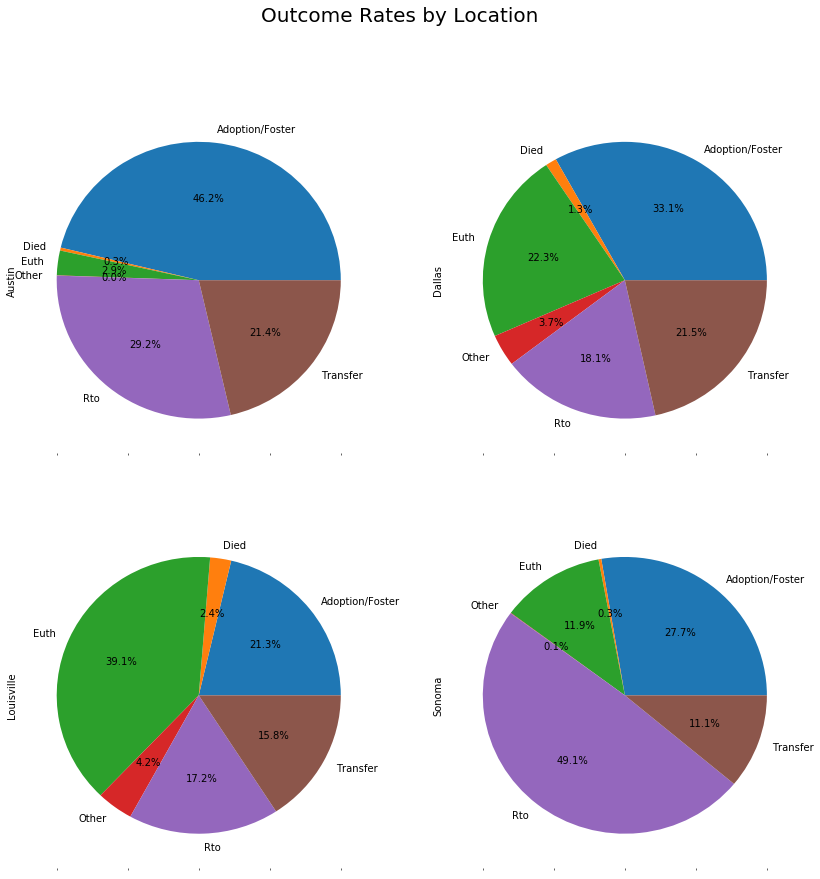

In [70]:
df = pd.pivot_table(merge_data, index = ['Outcome_Type'], values = 'Count', columns = 'Location', aggfunc = np.sum)

df.plot.pie(subplots = True, figsize =(14, 14), layout= [2,2], 
                    legend = False, autopct= '%1.1f%%')
plt.suptitle('Outcome Rates by Location', fontsize = 20)

Louisville leads with almost 40% of euthanization of all incoming dogs whereas other regions expects to have less than 25% euthanization. Adoption rate in Austin is expectionally high with 46% adoption compared to 2.9% euthanization. Austin tends to have one of the highest transfer rates accounting about 21% of total dogs entering the shelter. Interestingly 

## Breed distribution by Location and Outcome

Text(0.5,1,'Rate of Breed by Location')

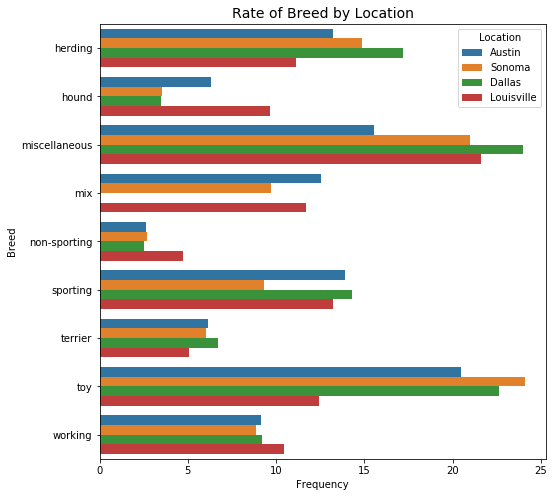

In [71]:
#bar graph of breed frequency by location
group_counts = (merge_data.groupby(['Location'])['Breed']
                .value_counts(normalize=True)
                .rename('Frequency')
                .mul(100)
                .reset_index()
                .sort_values('Breed').reset_index())
plt.ylabel('Dog Group')
sns.barplot(x = 'Frequency', y = 'Breed', hue = 'Location', data = group_counts)
plt.title('Rate of Breed by Location', fontsize = 14)

Generally speaking all these faciliities tend to have similar distribution of the types of dogs taken in at these facilities with a few exceptions. toy group and miscellaneous group leads with the highest intake rate than the other groups of dogs. Unsurpisingly, miscellanous group is one of the highest since most dog species are mix and pure breed is hard to distinguish and as a result, it's simplier for intakers to register the dog as a miscellanous instead of classifying them into a mix of two breeds. More suprisingly is the high rates of toy dogs among all regions. But more importantly, toy group intake at Louisville is more than 36% lower compared to the Austin, Sonoma and Dallas. This indicates toy toy groups are less uncommon in Louisville than other locations. Also Louisville tends to have higher intake of hound than the other locations. Sonoma has 33% lower in sporting intake than the next lowest. Louisville also have significantly higher rate of non-sporting and hound intake compared to other locations. Austin's and Dallas's intake behavior are similar. Dallas also does not include secondary breed as a part of their animal description and as a result does not have any counts in mix category. 

In [72]:
#explore adoption/foster outcomes by breed and location
adoption_counts = (merge_data[merge_data['Outcome_Type'] == 'Adoption/Foster']
                .groupby(['Location'])['Breed']
                .value_counts(normalize=True)
                .rename('Frequency')
                .mul(100)
                .reset_index()
                .sort_values('Breed').reset_index())

Text(0.5,0.98,'Adoption/Foster Behavior by Breed')

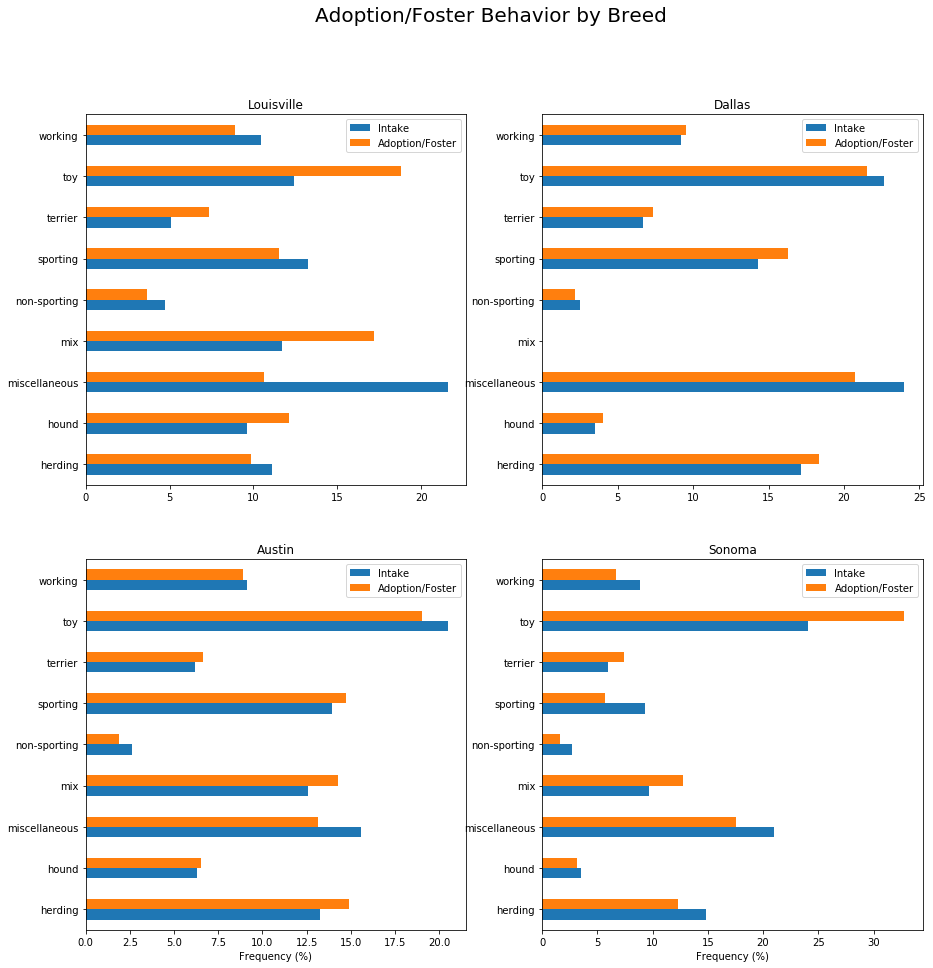

In [73]:
#setting intake = outcome, explore the adoptive nature by breed
breed_label= list(adoption_counts[adoption_counts['Location'] == 'Austin']['Breed'])
dallas_ad = list(adoption_counts[adoption_counts['Location'] == 'Dallas']['Frequency'])
dallas_in = list(group_counts[group_counts['Location'] == 'Dallas']['Frequency'])
dallas_ad.insert(3,0)
df_dallas_ad_in = pd.DataFrame({'Intake': dallas_in, 'Adoption/Foster': dallas_ad},index = breed_label)


austin_ad = list(adoption_counts[adoption_counts['Location'] == 'Austin']['Frequency'])
austin_in = list(group_counts[group_counts['Location'] == 'Austin']['Frequency'])
df_austin_ad_in = pd.DataFrame({'Intake': austin_in, 'Adoption/Foster': austin_ad}, index = breed_label)


sonoma_ad = list(adoption_counts[adoption_counts['Location'] == 'Sonoma']['Frequency'])
sonoma_in = list(group_counts[group_counts['Location'] == 'Sonoma']['Frequency'])
df_sonoma_ad_in = pd.DataFrame({'Intake': sonoma_in, 'Adoption/Foster': sonoma_ad}, index = breed_label)

louisville_ad = list(adoption_counts[adoption_counts['Location'] == 'Louisville']['Frequency'])
louisville_in = list(group_counts[group_counts['Location'] == 'Louisville']['Frequency'])
df_louisville_ad_in = pd.DataFrame({'Intake': louisville_in, 'Adoption/Foster': louisville_ad}, index = breed_label)

fig, axes = plt.subplots(2,2, figsize = (15,15))
df_louisville_ad_in.plot.barh(ax=axes[0,0])
df_dallas_ad_in.plot.barh(ax=axes[0,1])
df_austin_ad_in.plot.barh(ax=axes[1,0])
df_sonoma_ad_in.plot.barh(ax=axes[1,1])

axes[0,0].set_title('Louisville')
axes[0,1].set_title('Dallas')
axes[1,0].set_title('Austin')
axes[1,0].set_xlabel('Frequency (%)')
axes[1,1].set_title('Sonoma')
axes[1,1].set_xlabel('Frequency (%)')

fig.suptitle('Adoption/Foster Behavior by Breed', fontsize=20)

Generally, intake vs adoption/foster frequencies tends to align well which indicates a high positive correlation between intake distribution and adoption/foster distribution. However, it is noted that distribution of adotpion in Louisville and Sonoma tends to differ more from the distriubtion of intake rate. Again toy breed tends to achieve highest adoption/foster frequency. Interestingly toy breed adoption frequency outpaces intake frequencies in Sonoma and in Louisville. This indicates two potential scenarios or a hybrid of the forms. 1: Owners tends to adopt toy breeds more frequency in the region than other breeds. 2: Other breeds tends to have a lower adoption rate which proportionally improve the seemingly high adoption/foster rate of toy breeds.  There is a general trend in which miscellanous breeds tends to have lower adoption frequency than intake frequency with highest differential at Louisville by almost half. These graphs helps to formulate the adoption behaviors of the region and the transfer distribution should reflect the inverse of the region.

In [74]:
#explore euthanization outcomes by breed and location
euth_counts = (merge_data[merge_data['Outcome_Type'] == 'Euth']
                .groupby(['Location'])['Breed']
                .value_counts(normalize=True)
                .rename('Frequency')
                .mul(100)
                .reset_index()
                .sort_values('Breed'))

Text(0.5,0.98,'Euthanization Behavior by Breed')

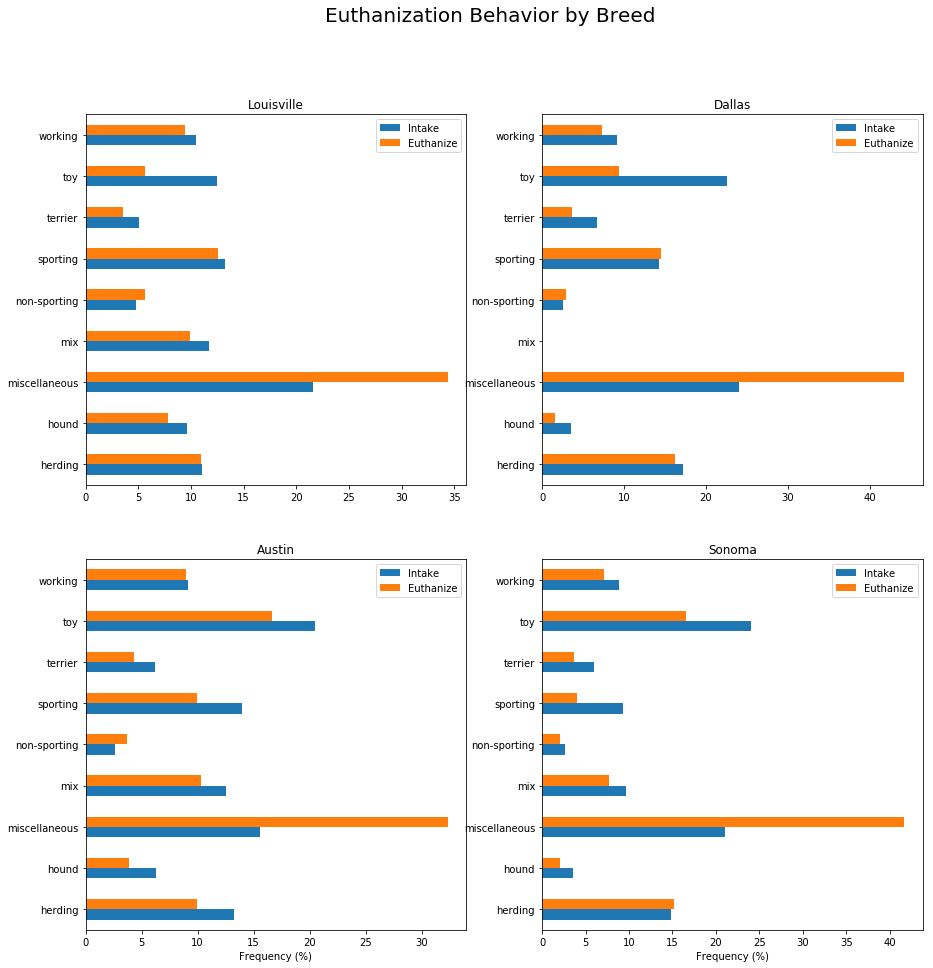

In [75]:
#setting intake = outcome, explore the euthaniztion nature by breed
dallas_eu = list(euth_counts[euth_counts['Location'] == 'Dallas']['Frequency'])
dallas_eu.insert(3,0)
df_dallas_eu_in = pd.DataFrame({'Intake': dallas_in, 'Euthanize': dallas_eu},index = breed_label)

austin_eu = list(euth_counts[euth_counts['Location'] == 'Austin']['Frequency'])
df_austin_eu_in = pd.DataFrame({'Intake': austin_in, 'Euthanize': austin_eu}, index = breed_label)

sonoma_eu = list(euth_counts[euth_counts['Location'] == 'Sonoma']['Frequency'])
df_sonoma_eu_in = pd.DataFrame({'Intake': sonoma_in, 'Euthanize': sonoma_eu}, index = breed_label)

louisville_eu = list(euth_counts[euth_counts['Location'] == 'Louisville']['Frequency'])
df_louisville_eu_in = pd.DataFrame({'Intake': louisville_in, 'Euthanize': louisville_eu}, index = breed_label)

fig, axes = plt.subplots(2,2, figsize = (15,15))
df_louisville_eu_in.plot.barh(ax=axes[0,0])
df_dallas_eu_in.plot.barh(ax=axes[0,1])
df_austin_eu_in.plot.barh(ax=axes[1,0])
df_sonoma_eu_in.plot.barh(ax=axes[1,1])

axes[0,0].set_title('Louisville')
axes[0,1].set_title('Dallas')
axes[1,0].set_title('Austin')
axes[1,0].set_xlabel('Frequency (%)')
axes[1,1].set_title('Sonoma')
axes[1,1].set_xlabel('Frequency (%)')

fig.suptitle('Euthanization Behavior by Breed', fontsize=20)

Distributions of intake and euthanization are completely different. Miscellaneous category of breed leads euthanization frequency with over 80% higher in euthanization frequency compared to intake frequency. Moreover toy breeds slides in euthanization frequency with Dallas and Louisville having more than 50% less in comparing frequencies, showing toy breeds tends to do well in survival at a shelter. Sporting dogs do exceptionally well in Sonoma and an overall trend of better survival rate. Terrier likewise do well. The inverse is true for non-euthanization groups

Text(0.5,0.98,'Transfer Behavior by Breed')

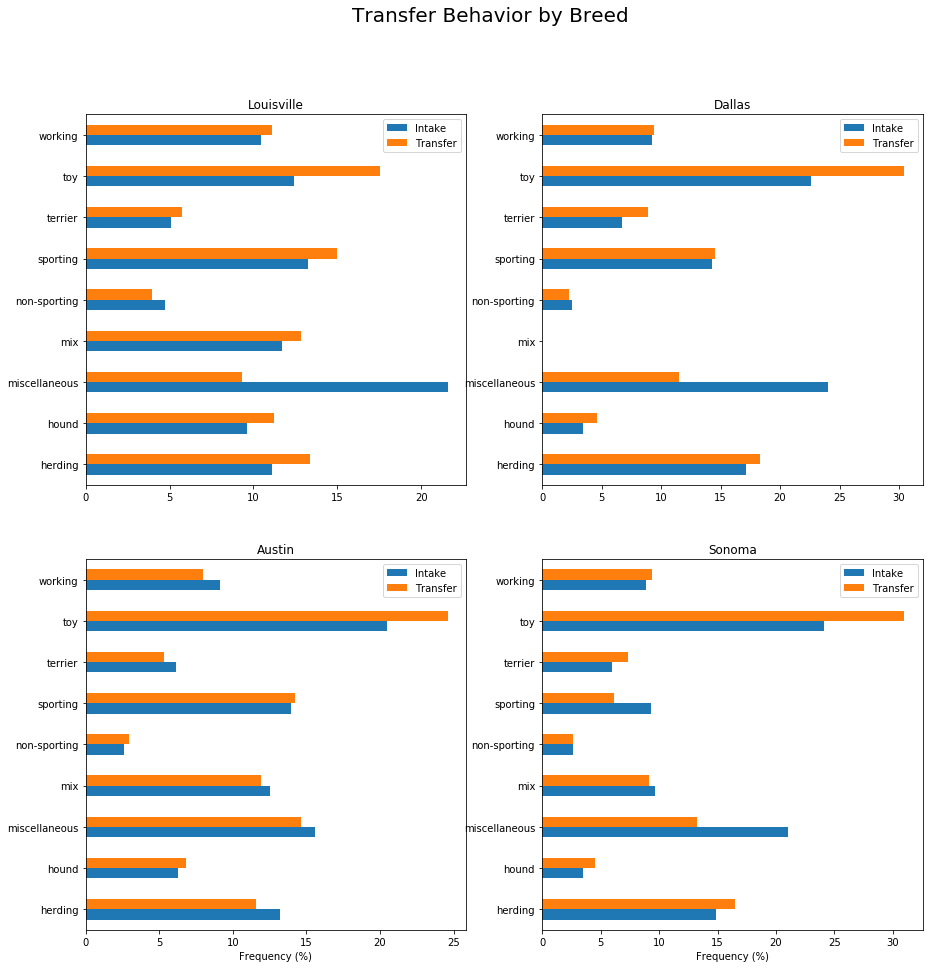

In [76]:
#explore euthanization outcomes by breed and location
trans_counts = (merge_data[merge_data['Outcome_Type'] == 'Transfer']
                .groupby(['Location'])['Breed']
                .value_counts(normalize=True)
                .rename('Frequency')
                .mul(100)
                .reset_index()
                .sort_values('Breed'))


#setting intake = outcome, explore the euthaniztion nature by breed
dallas_tr = list(trans_counts[trans_counts['Location'] == 'Dallas']['Frequency'])
dallas_tr.insert(3,0)
df_dallas_tr = pd.DataFrame({'Intake': dallas_in, 'Transfer': dallas_tr},index = breed_label)

austin_tr = list(trans_counts[trans_counts['Location'] == 'Austin']['Frequency'])
df_austin_tr = pd.DataFrame({'Intake': austin_in, 'Transfer': austin_tr}, index = breed_label)

sonoma_tr = list(trans_counts[trans_counts['Location'] == 'Sonoma']['Frequency'])
df_sonoma_tr = pd.DataFrame({'Intake': sonoma_in, 'Transfer': sonoma_tr}, index = breed_label)

louisville_tr = list(trans_counts[trans_counts['Location'] == 'Louisville']['Frequency'])
df_louisville_tr = pd.DataFrame({'Intake': louisville_in, 'Transfer': louisville_tr}, index = breed_label)

fig, axes = plt.subplots(2,2, figsize = (15,15))
df_louisville_tr.plot.barh(ax=axes[0,0])
df_dallas_tr.plot.barh(ax=axes[0,1])
df_austin_tr.plot.barh(ax=axes[1,0])
df_sonoma_tr.plot.barh(ax=axes[1,1])

axes[0,0].set_title('Louisville')
axes[0,1].set_title('Dallas')
axes[1,0].set_title('Austin')
axes[1,0].set_xlabel('Frequency (%)')
axes[1,1].set_title('Sonoma')
axes[1,1].set_xlabel('Frequency (%)')

fig.suptitle('Transfer Behavior by Breed', fontsize=20)

Transfer rates by toy breed overwhelmingly exceeds other breeds and the transfer percentage outpacing intake percentage. There appears to be some sort of mechanism for choosing breeds for transfer in these shelter that is independent of intake breeds

## Sex and Outcome

In [77]:
#pivot table of outcome type by sex and location
outcome_sex = pd.pivot_table(merge_data, values = 'Count', 
               index = ['Outcome_Type', 'Sex'], 
               columns = ['Location'], 
               aggfunc = np.sum, margins = True)

#define a percentage column
outcome_sex['Percentage'] = round(outcome_sex['All']/141109*100,2)

#calculate female, male, unknown percentage
female_pct = round(sum(merge_data[merge_data['Sex'] == 'Female']['Count'])/141109*100,1)
male_pct = round(sum(merge_data[merge_data['Sex'] == 'Male']['Count'])/141109*100,1)
unknown_pct = round(sum(merge_data[merge_data['Sex'] == 'Unknown']['Count'])/141109*100,2)

#create a dummy relative percentage column
outcome_sex['Relative Percentage'] = float(100)

#function to calculate relative percentage. Since unknown values is low, we can assume 50/50 calculation of male/female
i = 0
ind = 0
total = 0
for percent in outcome_sex['Percentage'][:-1]:
    if i == 0:
        outcome_sex['Relative Percentage'][ind] = outcome_sex['Percentage'][ind]/50*male_pct
    elif i == 1:
        outcome_sex['Relative Percentage'][ind] = outcome_sex['Percentage'][ind]/50*female_pct
    else:
        outcome_sex['Relative Percentage'][ind] = outcome_sex['Percentage'][ind]/50*unknown_pct
        i=-1
    total +=outcome_sex['Relative Percentage'][ind]
    i+=1
    ind+=1

outcome_sex['Relative Percentage'] = round(outcome_sex['Relative Percentage']/total*100,2)
outcome_sex['Relative Percentage'][-1] = float(100)

print('Female accounts for ' + str(female_pct)+ '% of the population')
print('Male accounts for ' + str(male_pct) + '% of the population')
print('Unknown accounts for ' + str(unknown_pct) + '% of the population')

outcome_sex

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Female accounts for 45.0% of the population
Male accounts for 53.8% of the population
Unknown accounts for 1.16% of the population


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Location                  Austin  Louisville  Sonoma     All  Percentage  \
Outcome_Type    Sex                                                        
Adoption/Foster Female   12386.0      7826.0  1214.0   21426       15.18   
                Male     13059.0      8569.0  1313.0   22941       16.26   
                Unknown      1.0         5.0     1.0       7        0.00   
Died            Female      79.0       763.0     8.0     850        0.60   
                Male        93.0       937.0    16.0    1046        0.74   
                Unknown     18.0       143.0     5.0     166        0.12   
Euth            Female     646.0     13110.0   435.0   14191       10.06   
                Male       908.0     16100.0   639.0   17647       12.51   
                Unknown     33.0       878.0    10.0     921        0.65   
Other           Female       8.0      1498.0     1.0    1507        1.07   
                Male        11.0      1678.0     3.0    1692        1.20   
                Unknown      NaN        19.0     1.0      20        0.01   
Rto             Female    6656.0      5392.0  1863.0   13911        9.86   
                Male      9345.0      7743.0  2598.0   19686       13.95   
                Unknown     53.0        65.0    23.0     141        0.10   
Transfer        Female    5520.0      5683.0   427.0   11630        8.24   
                Male      6040.0      6353.0   557.0   12950        9.18   
                Unknown    209.0       142.0    26.0     377        0.27   
All                      55065.0     76904.0  9140.0  141109      100.00   

Location                 Relative Percentage  
Outcome_Type    Sex                           
Adoption/Foster Female                 16.85  
                Male                   15.10  
                Unknown                 0.00  
Died            Female                  0.67  
                Male                    0.69  
                Unknown                 0.00  
Euth            Female                 11.17  
                Male                   11.62  
                Unknown                 0.02  
Other           Female                  1.19  
                Male                    1.11  
                Unknown                 0.00  
Rto             Female                 10.95  
                Male                   12.95  
                Unknown                 0.00  
Transfer        Female                  9.15  
                Male                    8.53  
                Unknown                 0.01  
All                                   100.00

Since, the relative percentage of sex differs in dogs at the shelter where female accounts for 45%, males accounts for 53.8% andthe remainder at 1.16%, it's much more appropriate to use relative percentage to understand the actual outcome behavior. As such some female and male percentages flipped. Examining adoption now, female adoption/foster have more than 1 percentage point higher than male adoption/foster. Euthanization rate among the two is relatively simialar with only 0.5% difference at 11.17% and 11.62% for female and male respectively. Male have 200 higher basis points above female for RTO ("return to owner"). Statistical analysis will further clarify the significance of the difference.

First, it's interesting to see that the spread between male and female intake proportion is almost 9%. We want to know whether male dogs are more likely to enter a shelter than a female dog. <br>
Null hypothesis = intake rate of male dog is equal to intake of female dog--p(male intake) = p(female intake) <br>
Alternative hypothesis: intake rate of male dog is higher than that of female dog--p(male intake) > p(female intake) <br>
alpha = 0.05

In [78]:
# find prop of female
female = sum(merge_data['Sex'] == 'Female')
male = sum(merge_data['Sex'] == 'Male')
total = female + male
prop = female/total

In [79]:
#simulation approach
np.random.seed(10)
simulate = np.empty(10000)
for i in range(10000):
    sample = np.mean(np.random.randint(2, size=total))
    simulate[i] = sample

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

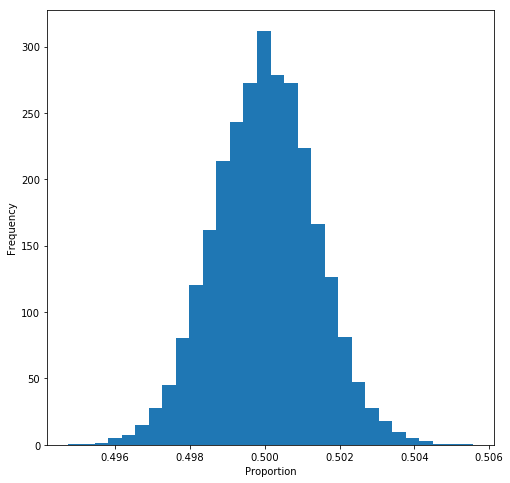

In [80]:
plt.hist(simulate, bins = 30, normed = True)
plt.xlabel('Proportion')
plt.ylabel('Frequency')

In [81]:
p_value = (np.sum(simulate >= (1-prop)))/10000
print('p-value:', p_value)

p-value: 0.0


In [82]:
#mathematical approach
stand_err = np.sqrt(.5*.5/total)
p_val = stats.norm.cdf((prop-.05)/stand_err)
print('p-value', p_value)

p-value 0.0


Because p-value is less than alpha, we reject the null hypothesis and accept the alternative hypothesis that female dogs tends to be end up in shelter less often than male dogs

Since the adoption proportionality between male and female is so similar, we like to conduct an hypothesis testing to verify the significance of the difference. <br>
Null hypothesis: Male adoption rate is equal to female adoption rate <br>
Alternative hypothesis: Male adoption rate is higher than female adoption rate. <br>
alpha = 0.05

In [83]:
data = merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
f = np.sum(data.Sex == 'Female')
m = np.sum(data.Sex == 'Male')
t = f+m
prop = f/t

In [84]:
sim = np.empty(10000)
for i in range(10000):
    sample = np.mean(np.random.randint(2,size = t))
    sim[i] = sample

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

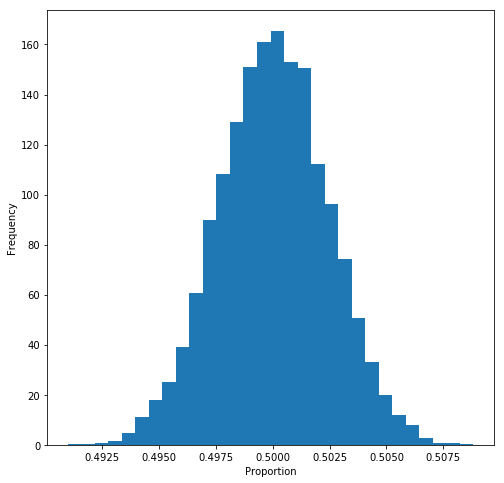

In [85]:
plt.hist(sim, bins = 30, normed = True)
plt.xlabel('Proportion')
plt.ylabel('Frequency')

In [86]:
p_value = (np.sum(sim>= (1-prop)))/10000
print('p-value:', p_value)

p-value: 0.0


Because p-value is less than alpha, we reject the null hypothesis and accept the alternative hypothesis that adoption rate of a female dog is higher than that of a male dog

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Text(0.5,1,'Rate of Outcome by Sex')

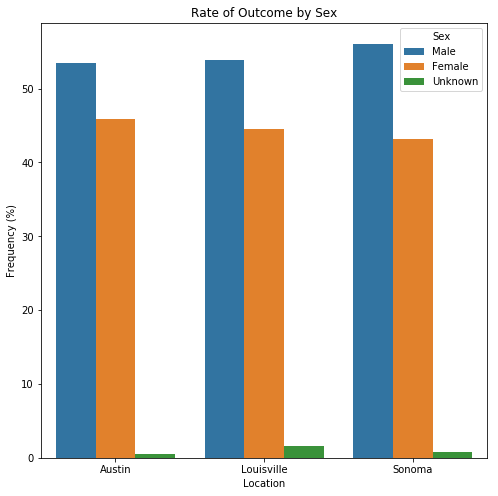

In [87]:
#Outcome by sex and location
sex_adopt = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Adoption/Foster']
            .groupby(['Location'])['Sex']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index())

sex_euth = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Euth']
            .groupby(['Location'])['Sex']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index())

sex_tr = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Transfer']
            .groupby(['Location'])['Sex']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index())

sex = (merge_data[merge_data.Location != 'Dallas']
            .groupby(['Location'])['Sex']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index())

sns.barplot(data = sex, x = 'Location', y = 'Frequency', hue = 'Sex')
plt.ylabel('Frequency (%)')
plt.title('Rate of Outcome by Sex')

More male dogs are taken to shelters than females or unknown genders with largest differential in sonoma

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Relative Transfer by Sex')

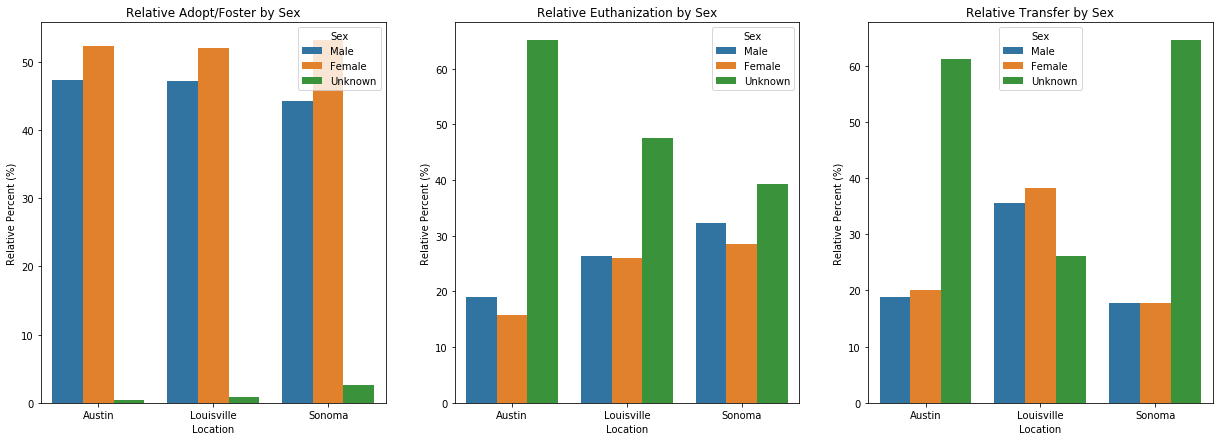

In [88]:
def relPCT(x, general):
    """calculate relative percentage using a general dataset onto x dataset"""
    """x = modifying dataframe"""
    """general = general dataframe from which absolute frequencies is extrapolated"""
    ind = 0
    x['Relative PCT'] = float(0)
    total = 0
    loc = len(x.Location.unique())
    len_x = len(x)
    check_ind = len_x/loc
    rel_val = []
    count = 1
    for percent in general.Frequency:
        x['Relative PCT'][ind] = x['Frequency'][ind]/percent
        total += x['Relative PCT'][ind]
        if count<check_ind:
            count+=1
        else:
            rel_val.append(total)
            count = 1
            total = 0
        ind+=1
    rel_val.append(0)
    count = 1
    total = rel_val[0]
    i = 0
    ind=0
    for num in x['Relative PCT']:
        x['Relative PCT'][ind] = x['Relative PCT'][ind]/total*100
        if count < check_ind:
            count +=1
        else:
            count = 1
            i +=1
            total = rel_val[i]
        ind+=1

relPCT(sex_adopt, sex)
relPCT(sex_euth, sex)
relPCT(sex_tr, sex)

#bar graph relative percentage of adoption and euthanization by sex discriminated by location
plt.figure(figsize = (21,7))
plt.subplot(1,3,1)
sns.barplot(data = sex_adopt, x = 'Location', y = 'Relative PCT', hue = 'Sex')
plt.title('Relative Adopt/Foster by Sex')
plt.ylabel('Relative Percent (%)')

plt.subplot(1,3,2)
sns.barplot(data = sex_euth, x = 'Location', y = 'Relative PCT', hue = 'Sex')
plt.title('Relative Euthanization by Sex')
plt.ylabel('Relative Percent (%)')

plt.subplot(1,3,3)
sns.barplot(data = sex_tr, x = 'Location', y = 'Relative PCT', hue = 'Sex')
plt.ylabel('Relative Percent (%)')
plt.title('Relative Transfer by Sex')

Even though male outpace females and unknown in entering shelter, female dogs tends to be more adoptable across all regions. Unknown genders do not typically get adopted. The opposite is true for ethanization where unknown gender are more likely to be euthanized, in particular Austin euthanization rate for unknown gender is 3 times higher than male dogs. Female tends to have the lowest euthanization rate but the differentail is small in Louisville that it could be statistical fluctuation. Unknown genders has a higher likelyhood of being transfer, however, based on the relative adoption and euthanization rates, it's unlikely transferring the dog types attributes to survival in the long run. Male and female is approximately equal in relative transfer rate wiht Austin and Louisville having higher fremale transfer rates.

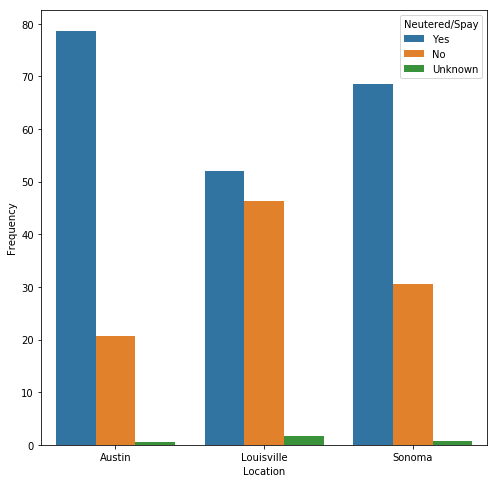

In [89]:
neut_spay = (merge_data[merge_data != 'Dallas'].groupby(['Location'])['Neutered/Spay']
             .value_counts(normalize = True)
             .mul(100)
             .rename('Frequency')
             .reset_index())
sns.barplot(data = neut_spay, x = 'Location', y = 'Frequency', hue = 'Neutered/Spay')

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5,1,'Rate of Outcome by Neutered/Spay')

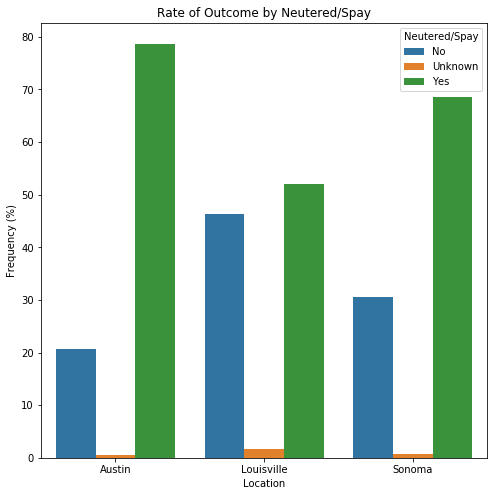

In [90]:
#Outcome by neutered and Location
neut_adopt = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Adoption/Foster']
            .groupby(['Location'])['Neutered/Spay']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index()
            .sort_values('Neutered/Spay'))


neut_euth = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Euth']
            .groupby(['Location'])['Neutered/Spay']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index()
            .sort_values('Neutered/Spay'))

neut_tr = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Transfer']
            .groupby(['Location'])['Neutered/Spay']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index()
            .sort_values('Neutered/Spay'))


neut = (merge_data[merge_data.Location != 'Dallas']
            .groupby(['Location'])['Neutered/Spay']
            .value_counts(normalize = True)
            .mul(100)
            .rename('Frequency')
            .reset_index()
            .sort_values('Neutered/Spay'))

sns.barplot(data = neut, x = 'Location', y = 'Frequency', hue = 'Neutered/Spay')
plt.ylabel('Frequency (%)')
plt.title('Rate of Outcome by Neutered/Spay')

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Relative Transfer by Neutered/Spay')

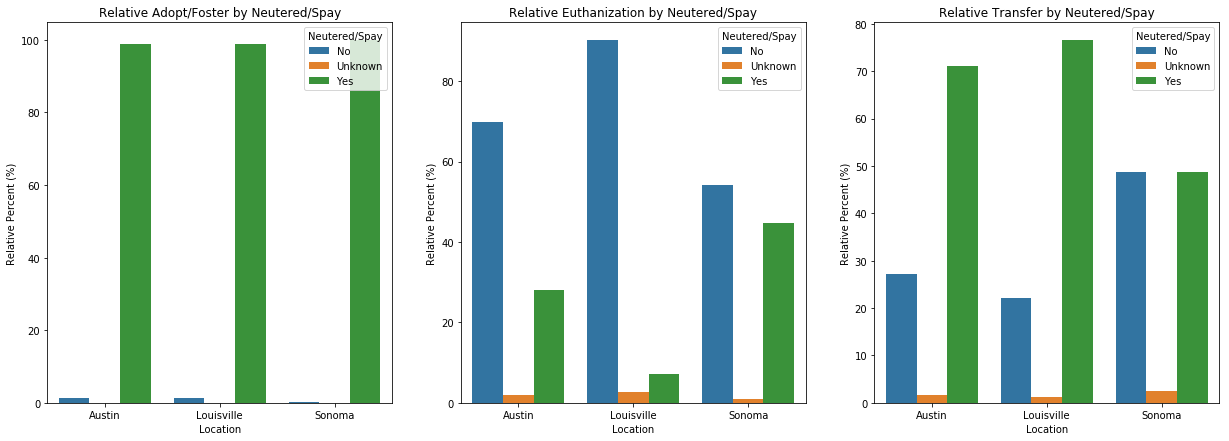

In [91]:
relPCT(neut_adopt, neut)
relPCT(neut_euth, neut)
relPCT(neut_tr, neut)

#bar graph relative percentage of adoption and euthanization by sex discriminated by location
plt.figure(figsize = (21,7))
plt.subplot(1,3,1)
sns.barplot(data = neut_adopt, x = 'Location', y = 'Relative PCT', hue = 'Neutered/Spay')
plt.title('Relative Adopt/Foster by Neutered/Spay')
plt.ylabel('Relative Percent (%)')

plt.subplot(1,3,2)
sns.barplot(data = neut_euth, x = 'Location', y = 'Relative PCT', hue = 'Neutered/Spay')
plt.title('Relative Euthanization by Neutered/Spay')
plt.ylabel('Relative Percent (%)')

plt.subplot(1,3,3)
sns.barplot(data = neut_tr, x = 'Location', y = 'Relative PCT', hue = 'Neutered/Spay')
plt.ylabel('Relative Percent (%)')
plt.title('Relative Transfer by Neutered/Spay')

Neuterizing and spaying dogs have a significant effect on adoption. Dogs that are euthanized tend to be dogs that are not neutered or spay with small relative fractives that are actually neutered. Most dogs that are transfered are also neutered or spayed. Sterilization for dogs tends to not have as dramatic effect on euthanization and transfer rates in Sonoma.

## Age Effect on Outcome

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Austin adoption median age is 1.1 years old
Louisville adoption median age is 1.1 years old
Sonoma adoption median age is 1.5 years old


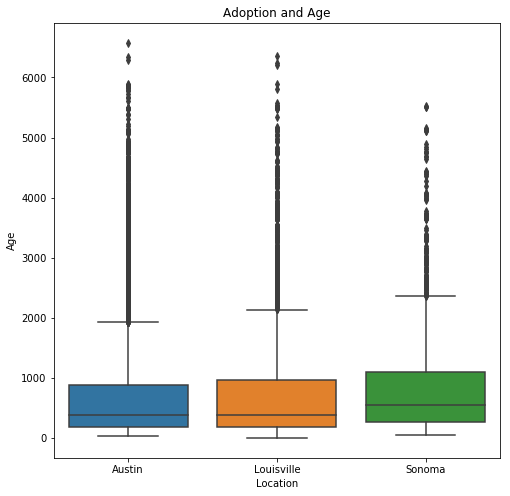

In [92]:
#grouping adoption by breed and age
merge_noDallas_adopt = (merge_data[merge_data['Location'] != 'Dallas']
                  [merge_data['Outcome_Type'] == 'Adoption/Foster']
                  .sort_values(['Location', 'Breed']))
sns.boxplot(x='Location', y = 'Age', data = merge_noDallas_adopt)
plt.title('Adoption and Age')
median_age_adopt = (merge_noDallas_adopt.groupby('Location')['Age']
              .median().rename('Median')
              .reset_index())

print('Austin adoption median age is', round(median_age_adopt.Median[0]/365, 1), 'years old')
print('Louisville adoption median age is', round(median_age_adopt.Median[1]/365, 1), 'years old')
print('Sonoma adoption median age is', round(median_age_adopt.Median[2]/365, 1), 'years old')

In [93]:
sono = (merge_data[merge_data['Location'] == 'Sonoma']
         [merge_data['Outcome_Type'] == 'Adoption/Foster']
         ['Age'].dropna())
louis = (merge_data[merge_data['Location'] == 'Louisville']
        [merge_data['Outcome_Type'] == 'Adoption/Foster']
        ['Age'].dropna())
aust = (merge_data[merge_data['Location'] == 'Austin']
        [merge_data['Outcome_Type'] == 'Adoption/Foster']
        ['Age'].dropna())
mean_l = np.mean(louis)
mean_s = np.mean(sono)
mean_a = np.mean(aust)
diff = mean_a - mean_l

print('Austin adoption mean age is', round(mean_a/365, 1), 'years old')
print('Louisville adoption mean age is', round(mean_l/365, 1), 'years old')
print('Sonoma adoption mean age is', round(mean_s/365, 1), 'years old')

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Austin adoption mean age is 2.1 years old
Louisville adoption mean age is 2.0 years old
Sonoma adoption mean age is 2.4 years old


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Sonoma's adoption rate is less susceptible to age and has a higher median age of adoption than that of both Austin and Louisville. On the other hand, Austin and Louisville have similar median age for adoption. To test this, a bootstrap approach to analyzing actual median difference between Sonoma and Louisville to examine whether the difference is significant. 

Null hypothesis: The adoption average age of Austin and that of Louisville are the same <br>
Alternative hypthoesis: The adoption average age of Austin is greater than that of Louisville <br>
alpha = .05

In [94]:
#bootstrap permutation approach
combined_df = aust.append(sono)
diff = mean_a - mean_l
store_perm = np.empty(10000)
for i in range(10000):
    perm = np.random.choice(combined_df, size = len(combined_df))
    boot_mean_a = np.mean(perm[:len(aust)])
    boot_mean_l = np.mean(perm[len(aust):])
    diff_mean = boot_mean_a - boot_mean_l
    store_perm[i] = diff_mean

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Bootstrap Distribution of Mean Difference')

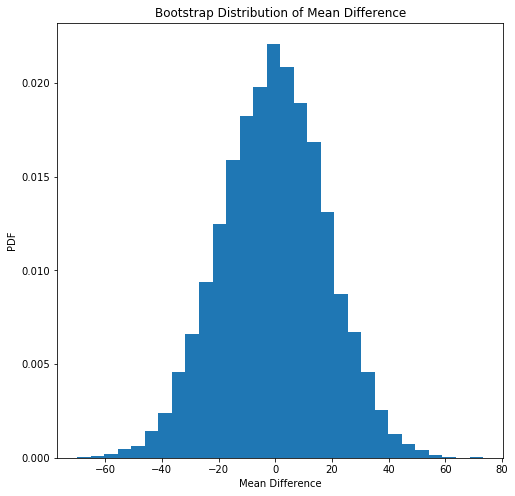

In [95]:
#plot the histogram of the bootstrap mean difference
plt.hist(store_perm, bins = 30, normed = True)
plt.xlabel('Mean Difference')
plt.ylabel('PDF')
plt.title('Bootstrap Distribution of Mean Difference')

In [96]:
p = np.sum(store_perm >= diff)/10000
print('p-value is', p)

p-value is 0.0133


Because p-value is lower than alpha of 0.5, we reject the null hypothesis and accept the alternative hypothesis that Austin has a larger average age of adoption than Louisville.

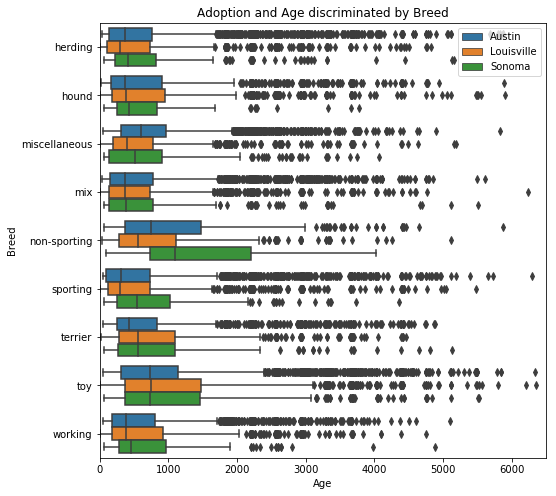

In [97]:
#adoption rate by breed and age
sns.boxplot(x='Age', y = 'Breed', hue = 'Location', data = merge_noDallas_adopt)
plt.title('Adoption and Age discriminated by Breed')
plt.xlim((0,6500))
plt.legend(loc = 'upper right')

Toy breed stood out having higher median age for adoption than other breeds on average. Non-sporting in Sonoma and Austin have medians age than toy but non-sporting median age is significantly less than that of toy in Lousiville. Hound and sporting breed have the lowest median age of adoption. Overall the adoptive behavior in different region generally is similar with the exception of non-sporting and miscellaneous species

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Austin euthanization median age is 3.0 years old
Louisville euthanization median age is 2.5 years old
Sonoma euthanization median age is 3.1 years old


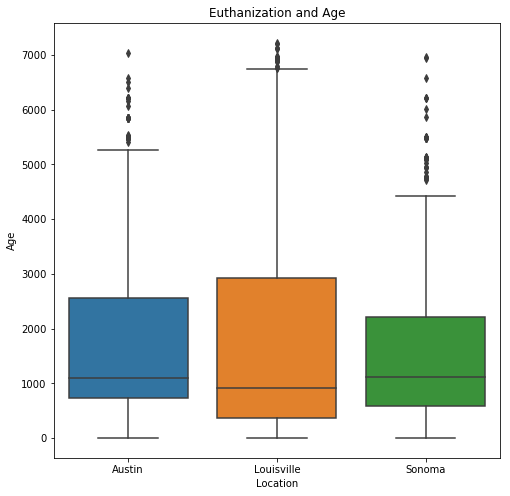

In [98]:
#grouping euthanization by breed and age
merge_noDallas_euth = (merge_data[merge_data['Location'] != 'Dallas']
                  [merge_data['Outcome_Type'] == 'Euth']
                  .sort_values(['Location', 'Breed']))
sns.boxplot(x='Location', y = 'Age', data = merge_noDallas_euth)
plt.title('Euthanization and Age')

median_age_euth = (merge_noDallas_euth.groupby('Location')['Age']
              .median().rename('Median')
              .reset_index())

print('Austin euthanization median age is', round(median_age_euth.Median[0]/365,1), 'years old')
print('Louisville euthanization median age is', round(median_age_euth.Median[1]/365,1), 'years old')
print('Sonoma euthanization median age is', round(median_age_euth.Median[2]/365,1), 'years old')

In [99]:
sono = (merge_data[merge_data['Location'] == 'Sonoma']
         [merge_data['Outcome_Type'] == 'Euth']
         ['Age'].dropna())
louis = (merge_data[merge_data['Location'] == 'Louisville']
        [merge_data['Outcome_Type'] == 'Euth']
        ['Age'].dropna())
aust = (merge_data[merge_data['Location'] == 'Austin']
        [merge_data['Outcome_Type'] == 'Euth']
        ['Age'].dropna())
mean_l = np.mean(louis)
mean_s = np.mean(sono)
mean_a = np.mean(aust)
diff = mean_l - mean_s

print('Austin euthanization mean age is', round(mean_a/365, 1), 'years old')
print('Louisville euthanization mean age is', round(mean_l/365, 1), 'years old')
print('Sonoma euthanization mean age is', round(mean_s/365, 1), 'years old')

Austin euthanization mean age is 4.7 years old
Louisville euthanization mean age is 4.8 years old
Sonoma euthanization mean age is 4.6 years old


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Louisville is more discriminating against age in terms of euthanization with a median euthanization age of 2.5 years old as opposed to 3 years old for both Austin and Sonoma. However, the mean age of euthanization for all location is about 4.7 years old, showing that the distribution is extremely right skewed. Because the mean euthanization ages are so similar in all three locations, we should test whether they are the same.
<br>
<br>
Null hypothesis: Mean euthanization rate of Louisville and that of Austin are the same <br>
Alternative hypothesis: Mean Euthanization rate of louisville and Austin  are different <br>
alpha = 0.05

In [100]:
combined = louis.append(sono)

#bootstrap
sim = np.empty(10000)
for i in range(10000):
    perm = np.random.choice(combined, size = len(combined))
    bootmean_s = np.mean(perm[:len(sono)])
    bootmean_l = np.mean(perm[len(sono):])
    boot_diff = bootmean_l-bootmean_s
    sim[i] = boot_diff

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

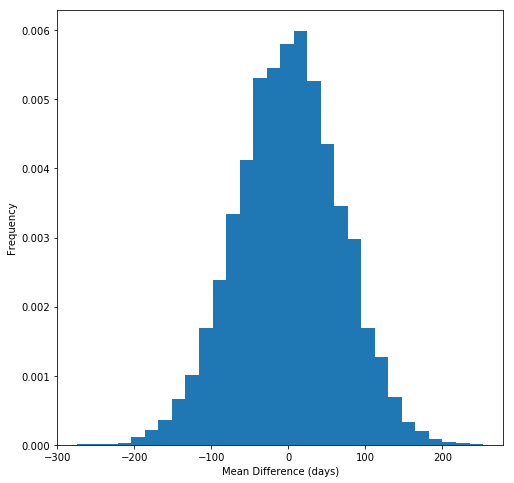

In [101]:
plt.hist(sim, bins = 30, normed = True)
plt.xlabel('Mean Difference (days)')
plt.ylabel('Frequency')

In [102]:
p_value = (np.sum(sim >= diff) + np.sum(sim <= -diff))/10000
print('p-value :', p_value)

p-value : 0.1937


Because the p-value is greater than alpha, we accept the null hypothesis and reject the alternative hypothesis.

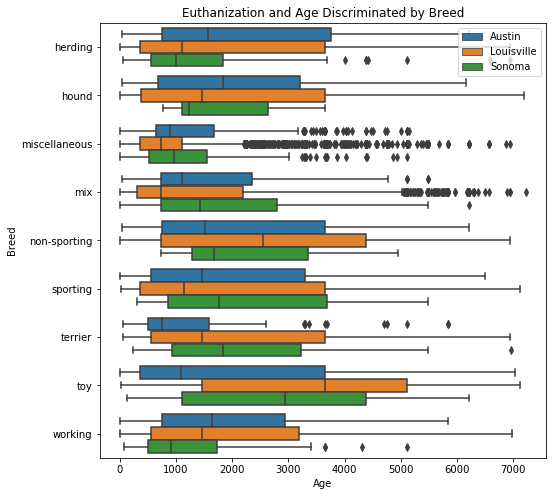

In [103]:
sns.boxplot(x='Age', y = 'Breed', hue = 'Location', data = merge_noDallas_euth)
plt.title('Euthanization and Age Discriminated by Breed')
plt.legend(loc = 'upper right')

y = 1.579x + 692.694
r-value: 0.187


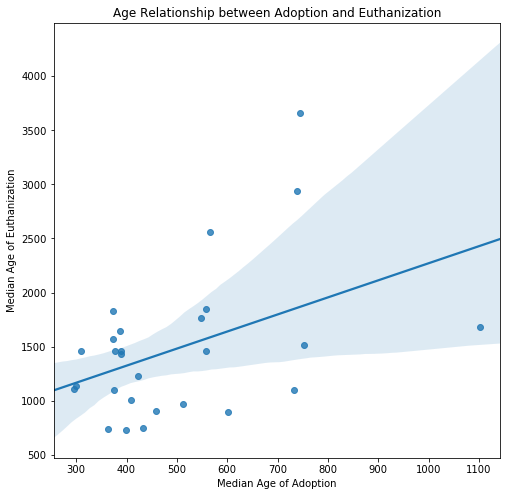

In [104]:
median_euth = (merge_noDallas_euth.groupby(['Location', 'Breed'])
               ['Age'].median()
               .rename('Median_Age')
               .reset_index())

median_adopt = (merge_noDallas_adopt.groupby(['Location', 'Breed'])
               ['Age'].median()
               .rename('Median_Age')
               .reset_index())

sns.regplot(x = median_adopt.Median_Age, y = median_euth.Median_Age)
plt.xlabel('Median Age of Adoption')
plt.ylabel('Median Age of Euthanization')
plt.title('Age Relationship between Adoption and Euthanization')
slope, intercept, r_value, p_value, std_err = stats.linregress(x = median_adopt.Median_Age, y = median_euth.Median_Age)
print('y = ' + str(round(slope, 3)) + 'x + ' + str(round(intercept, 3)))
print('r-value:', round(r_value**2, 3))

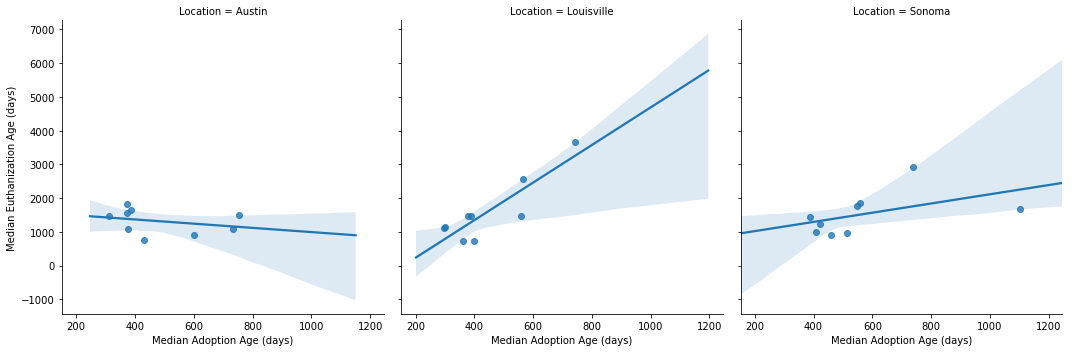

In [105]:
result = pd.merge(median_adopt, median_euth, how = 'inner', on = ['Location', 'Breed'])
result = result.rename(columns = {'Median_Age_x': 'Median Adoption Age (days)',
                         'Median_Age_y': 'Median Euthanization Age (days)'})
sns.lmplot(x = 'Median Adoption Age (days)', y = 'Median Euthanization Age (days)', col = 'Location', data = result)

In [106]:
#create a statistical table of the regression 
def stat_table(dataframe, ind, Location, x_name, y_name):
    result = {}
    for i in range(len(Location)):
        x = dataframe[x_name][ind*i:ind*i+ind]
        y = dataframe[y_name][ind*i:ind*i+ind]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x , y)
        if 'regression' in result:
            result['regression'].append('y = ' + str(round(slope, 3)) + 'x + ' + str(round(intercept, 3)))
        else:
            result['regression'] = ['y = ' + str(round(slope, 3)) + 'x + ' + str(round(intercept, 3))]
        if 'r square' in result:
            result['r square'].append(round(r_value**2, 3))
        else:
            result['r square'] = [round(r_value**2, 3)]
        if 'p_value' in result:
            result['p_value'].append(round(p_value, 3))
        else:
            result['p_value'] = [round(p_value, 3)]
    result['Location'] = Location
    df_result = pd.DataFrame(data = result)
    return df_result.set_index('Location')
stat_table(result, 9, ['Austin', 'Louisville', 'Sonoma'], 
           'Median Adoption Age (days)', 'Median Euthanization Age (days)')

,regression,r square,p_value
Location,,,
Austin,y = -0.623x + 1619.11,0.080,0.459
Louisville,y = 5.571x + -879.339,0.765,0.002
Sonoma,y = 1.365x + 751.324,0.235,0.186


Age shows a statistically significant p value to the model created for Louisville and that age is a contributor the the euthanization and adoption rates of dogs at Louisville. Generally speaking by understand the adoption rate for the type of breed for a dog at Louisville, we can project the median age for which the dog could be executed. This also states that in Louisville the distribution of dogs age for euthanized dogs are the same as that for adoption dogs. Even though age clearly shows a discriminatory effect on outcome, we can roughly project adoption rate and euthanization rate with a factor.

## Purity of animals on Outcome

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


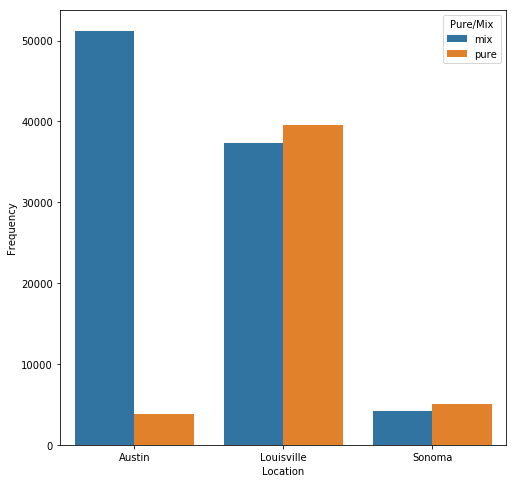

In [107]:
pure_mix_adopt = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Adoption/Foster']
            .groupby(['Location'])['Pure/Mix']
            .value_counts()
            .rename('Frequency')
            .reset_index())

pure_mix_euth = (merge_data[merge_data.Location != 'Dallas'][merge_data.Outcome_Type == 'Euth']
                 .groupby(['Location'])['Pure/Mix']
                 .value_counts()
                 .rename('Frequency')
                 .reset_index())

pure_mix = (merge_data[merge_data.Location != 'Dallas']
            .groupby(['Location'])['Pure/Mix']
            .value_counts()
            .rename('Frequency')
            .reset_index())

sns.barplot(data = pure_mix, x = 'Location', y = 'Frequency', hue = 'Pure/Mix')

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Euthanization by Breed Purity')

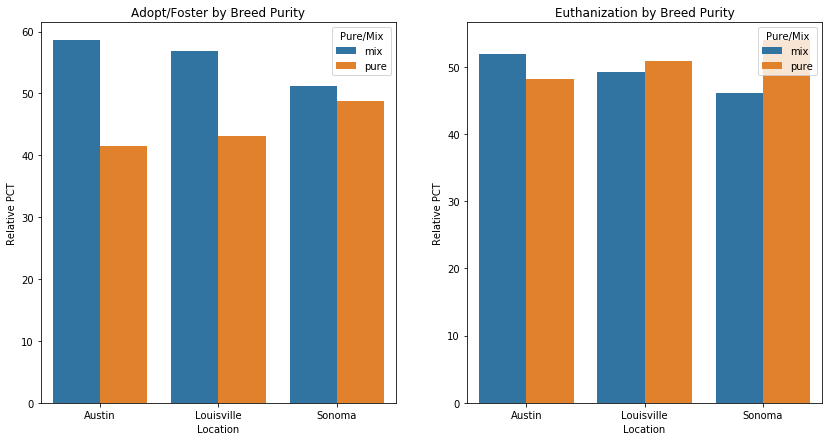

In [108]:
#create a relative percentage column to normalize the results
relPCT(pure_mix_euth, pure_mix)
relPCT(pure_mix_adopt, pure_mix)

#plot the relative percentage as bar graphs
plt.figure(figsize = (14,7))
plt.subplot(1,2,1)
sns.barplot(data = pure_mix_adopt, x = 'Location', y = 'Relative PCT', hue = 'Pure/Mix')
plt.title('Adopt/Foster by Breed Purity')

plt.subplot(1,2,2)
sns.barplot(data = pure_mix_euth, x = 'Location', y = 'Relative PCT', hue = 'Pure/Mix')
plt.title('Euthanization by Breed Purity')

## Color on the Outcome

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


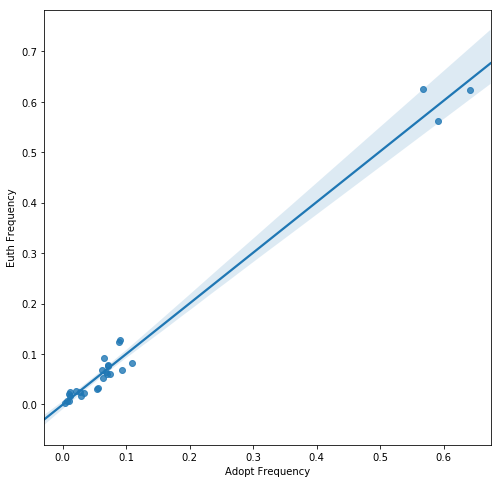

In [109]:
color_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
               [merge_data['Location'] != 'Dallas']
               .groupby(['Location'])['Color']
               .value_counts(normalize = True)
               .rename('Adopt Frequency').reset_index()
               .sort_values(['Location', 'Color']).reset_index())  
               
color_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
              [merge_data['Location'] != 'Dallas']
               .groupby(['Location'])['Color']
               .value_counts(normalize = True)
               .rename('Frequency').reset_index()
             .sort_values(['Location', 'Color']).reset_index())  

color_adopt['Euth Frequency'] = color_euth.Frequency

sns.regplot(x = 'Adopt Frequency', y = 'Euth Frequency', data = color_adopt)

In [110]:
#formulate a table with statistical information of the above regression plot
x = color_adopt['Adopt Frequency']
y = color_adopt['Euth Frequency']
slope, intercept, r_value, p_value, std_err = stats.linregress(x , y)
print('y = ' + str(round(slope, 3)) + 'x + ' + str(round(intercept, 3)))
print('r-value:', round(r_value**2, 3))

y = 1.004x + -0.0
r-value: 0.987


The regression shows high correlation between adoption frequency and euthanization frequency if the frequencies were discriminated by color. However, the resulting regression equation shows 1:1 proportionality between the two frequencies. In other words, this special case indicates that if the distribution of color is known for a group of dogs and the adoption and euthanization rates are also known, a simiple element-wise multiplication would indicate how many of the dogs would be put up for adoption and euthanization. In other words, the distribution of dogs color for euthanization and adoption is the same.

## Intake Type on Outcome

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match Dat

Text(0.5,1,'Adopt/Foster by Intake Type')

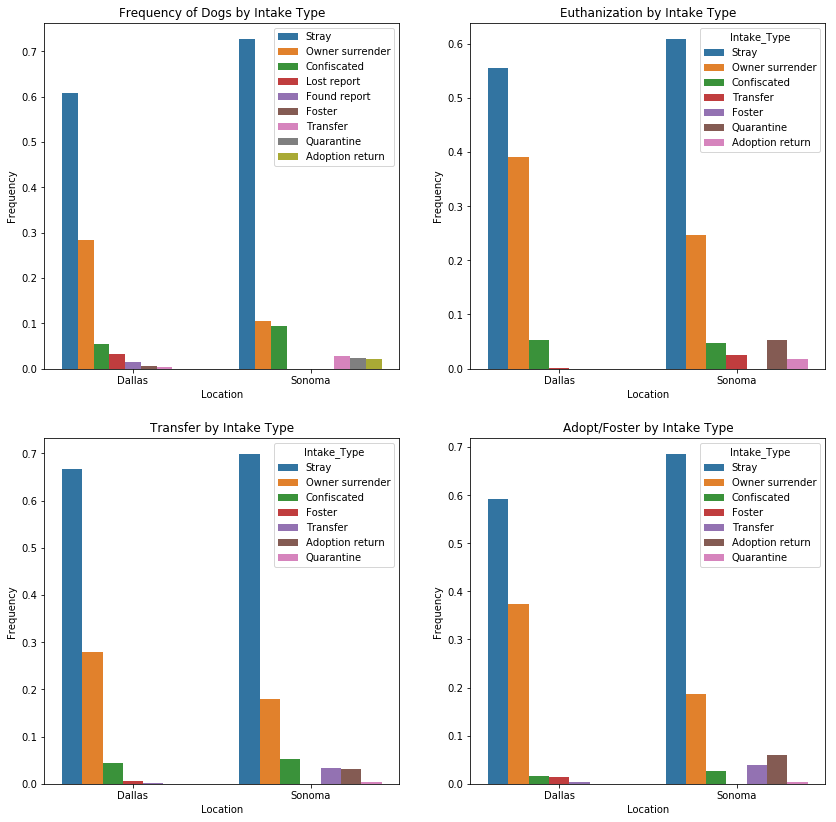

In [111]:
intaketype = (merge_data[merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Type']
              .value_counts(normalize = True)
              .rename('Frequency').reset_index()
              .sort_values(['Location']).reset_index())

intaketype_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
               [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Type']
               .value_counts(normalize = True)
               .rename('Frequency').reset_index()
               .sort_values(['Location']).reset_index())  
               
intaketype_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
              [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Type']
                .value_counts(normalize = True)
                .rename('Frequency').reset_index()
                .sort_values(['Location']).reset_index())

intaketype_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
              [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Type']
                .value_counts(normalize = True)
                .rename('Frequency').reset_index()
                .sort_values(['Location']).reset_index())



#plot the percentage as bar graphs
plt.figure(figsize = (14,14))
plt.subplot(2,2,1)
sns.barplot(data = intaketype, x = 'Location', y = 'Frequency', hue = 'Intake_Type')
plt.title('Frequency of Dogs by Intake Type')
plt.legend(loc = 'upper right')

plt.subplot(2,2,2)
sns.barplot(data = intaketype_euth, x = 'Location', y = 'Frequency', hue = 'Intake_Type')
plt.title('Euthanization by Intake Type')

plt.subplot(2,2,3)
sns.barplot(data = intaketype_tr, x = 'Location', y = 'Frequency', hue = 'Intake_Type')
plt.title('Transfer by Intake Type')

plt.subplot(2,2,4)
sns.barplot(data = intaketype_adopt, x = 'Location', y = 'Frequency', hue = 'Intake_Type')
plt.title('Adopt/Foster by Intake Type')

Stray dogs leads all type of outcome with higher percentage of dogs being taken in as a stray dog. Euthanization have disproportionately have higher owner surrender dogs than the inake rates. Quarantine dogs tends to be euthanized as well. Confiscated animals tends to not become adoptable but instead transfer to another shelter. Overall transfer rates for these shelters are very small.

## Intake Conditions on Outcome

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match Dat

Text(0.5,1,'Adopt/Foster by Intake Condition')

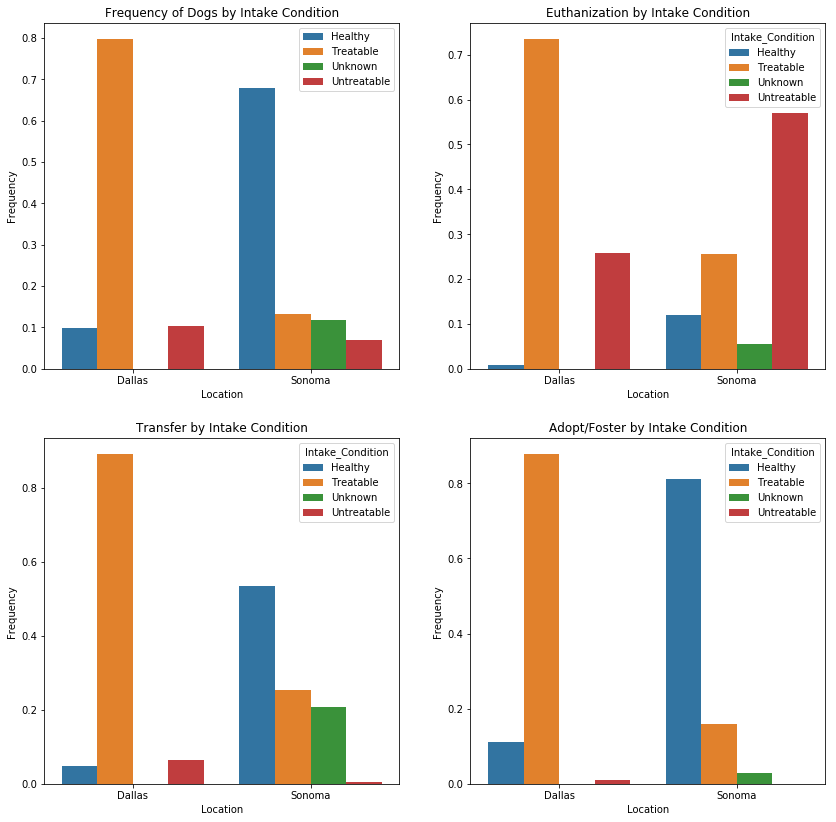

In [112]:
intakecon = (merge_data[merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Condition']
              .value_counts(normalize = True)
              .rename('Frequency').reset_index()
              .sort_values(['Location']).reset_index()).sort_values('Intake_Condition')

intakecon_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
               [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Condition']
               .value_counts(normalize = True)
               .rename('Frequency').reset_index()
               .sort_values(['Location']).reset_index()).sort_values('Intake_Condition')
               
intakecon_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
              [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Condition']
                .value_counts(normalize = True)
                .rename('Frequency').reset_index()
                .sort_values(['Location']).reset_index()).sort_values('Intake_Condition')

intakecon_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
              [merge_data['Location'] != 'Louisville']
              [merge_data['Location'] != 'Austin']
              .groupby(['Location'])['Intake_Condition']
                .value_counts(normalize = True)
                .rename('Frequency').reset_index()
                .sort_values(['Location']).reset_index()).sort_values('Intake_Condition')



#plot the percentage as bar graphs
plt.figure(figsize = (14,14))
plt.subplot(2,2,1)
sns.barplot(data = intakecon, x = 'Location', y = 'Frequency', hue = 'Intake_Condition')
plt.title('Frequency of Dogs by Intake Condition')
plt.legend(loc = 'upper right')

plt.subplot(2,2,2)
sns.barplot(data = intakecon_euth, x = 'Location', y = 'Frequency', hue = 'Intake_Condition')
plt.title('Euthanization by Intake Condition')

plt.subplot(2,2,3)
sns.barplot(data = intakecon_tr, x = 'Location', y = 'Frequency', hue = 'Intake_Condition')
plt.title('Transfer by Intake Condition')

plt.subplot(2,2,4)
sns.barplot(data = intakecon_adopt, x = 'Location', y = 'Frequency', hue = 'Intake_Condition')
plt.title('Adopt/Foster by Intake Condition')

For Dallas it's surprising to see sizable percentage of untreatable dogs are transferred. Sonoma have around 10% of dogs being euthanized that are in healthy condition compared to nearly negligible amount in Dallas. This area should be targeted to improve outcomes for dogs since sonoma has the lowest percentage of transfer rates among all location with 10% of all intake dogs. Both Sonoma and Dallas have high percentage of euthanization for sick but treatable cases of dogs

## Time Series

Text(0.5,1,'Outcome by Year')

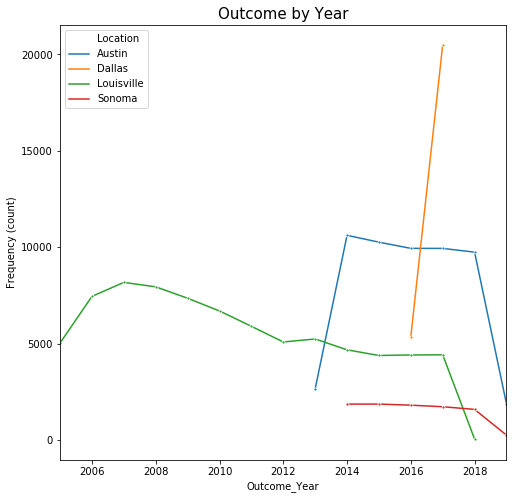

In [113]:
#line graph trends of outcome rate by yearly basis
Year_count = (merge_data.groupby(['Location'])['Outcome_Year']
                .value_counts()
                .rename('Frequency')
                .reset_index())

g = sns.lineplot(data = Year_count, x = 'Outcome_Year', y = 'Frequency', hue='Location', marker = ".")
plt.xlim((2005,2019))
plt.ylabel('Frequency (count)')
plt.title('Outcome by Year', fontsize = 15)

A steep decline towards the end of the last year of data across all location likely indicates the data was terminated in the middle of the year or data was incomplete. Also only 2 years of Dallas' data are present. When analyzing time data, these two points should be kept in mind. between 2006 and 2010, Louisvilles has abnormally high outcome. Lousiville has been experiencing a decline in outcome rate since 2007.

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,'Frequency (count)')

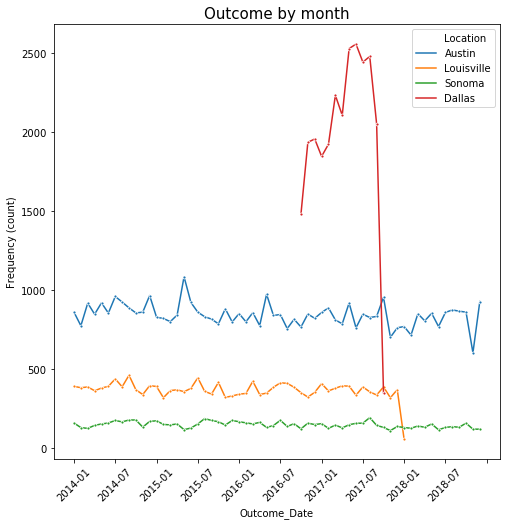

In [114]:
#examining seasonal change grouping the outcome by month and location
month_year = (merge_data.groupby(['Location'])['Outcome_Date']
                .value_counts()
                .rename('Frequency')
                .reset_index().sort_values('Outcome_Date'))
lim_month_year = month_year[month_year.Outcome_Date > '2014'][month_year.Outcome_Date <'2019']
g = sns.lineplot(data = lim_month_year, x = 'Outcome_Date', y = 'Frequency', hue='Location', marker = ".")
plt.setp(g.get_xticklabels(), rotation=45)
g.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.title('Outcome by month', fontsize = 15)
plt.ylabel('Frequency (count)')

Austin appears to have high outcome rates around May every year and Louisville experiences similar reaction at around August. Again we see an abnormal steep decline in outcome towards the end of the dataset. Overall, the data is quite stable in outcome by month between 2014 and 2019.

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Us

Text(0.5,0.98,'Outcome Frequency by Month')

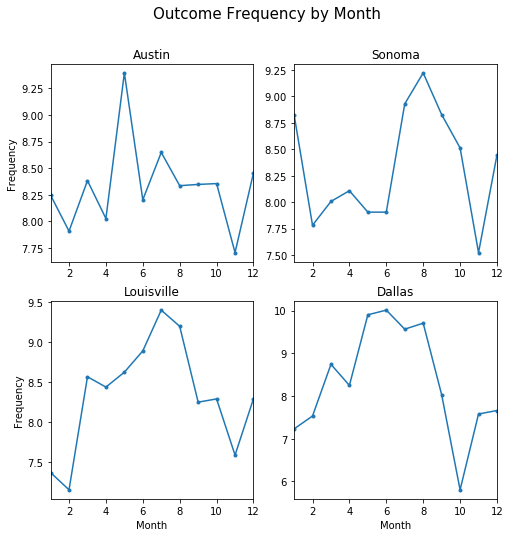

In [115]:
#restricting outcome date to year to year to reduce overcompensation of extra months in the dataset
#also remove the steep rise and decline in the dataset
austin_outcome = (merge_data[merge_data['Location'] == 'Austin']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

sonoma_outcome = (merge_data[merge_data['Location'] == 'Sonoma']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_outcome = (merge_data[merge_data['Location'] == 'Louisville']
                  [merge_data['Outcome_Date'] < '2018']
                 [merge_data['Outcome_Date'] > '2005']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_outcome = (merge_data[merge_data['Location'] == 'Dallas']
                  [merge_data['Outcome_Date'] < '2017-10']
                  [merge_data['Outcome_Date'] > '2016-09']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

#plot the frequencies as a function of months to abserve seasonal change in outcome rates
plt.subplot(2,2,1)
plt.plot(austin_outcome['index'],austin_outcome['Frequency'], marker = '.')
plt.title('Austin')
plt.ylabel('Frequency')
plt.xlim((1,12))
plt.subplot(2,2,2)
plt.plot(sonoma_outcome['index'],sonoma_outcome['Frequency'], marker = '.')
plt.title('Sonoma')
plt.xlim((1,12))
plt.subplot(2,2,3)
plt.plot(louis_outcome['index'],louis_outcome['Frequency'], marker = '.')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.subplot(2,2,4)
plt.plot(dallas_outcome['index'],dallas_outcome['Frequency'], marker = '.')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.suptitle('Outcome Frequency by Month', fontsize = 15)

Looking at the frequency of each location, it is safe to assert that for most location outcome rates peaks at certain time of the year. For example Austin has highest outcome in May and lowest in November with an improvement of 30%. For Sonoma, Louisville, and Dallas, outcome rates tends to peak in the summer between May and September. November tends to have lowest outcome for all Locations and typically slowdown in outcome rates in winter.

In [116]:
#investigate the adoption and euthanization rate by season
#restricting outcome date to year to year to reduce overcompensation of extra months in the dataset
#also remove the steep rise and decline in the dataset
austin_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
                [merge_data['Location'] == 'Austin']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

sonoma_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
                [merge_data['Location'] == 'Sonoma']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
                [merge_data['Location'] == 'Louisville']
                  [merge_data['Outcome_Date'] < '2018']
                 [merge_data['Outcome_Date'] > '2005']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_adopt = (merge_data[merge_data.Outcome_Type == 'Adoption/Foster']
                [merge_data['Location'] == 'Dallas']
                  [merge_data['Outcome_Date'] < '2017-10']
                  [merge_data['Outcome_Date'] > '2016-09']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

austin_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
                [merge_data['Location'] == 'Austin']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

sonoma_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
                [merge_data['Location'] == 'Sonoma']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
                [merge_data['Location'] == 'Louisville']
                  [merge_data['Outcome_Date'] < '2018']
                 [merge_data['Outcome_Date'] > '2005']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_euth = (merge_data[merge_data.Outcome_Type == 'Euth']
                [merge_data['Location'] == 'Dallas']
                  [merge_data['Outcome_Date'] < '2017-10']
                  [merge_data['Outcome_Date'] > '2016-09']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

austin_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
                [merge_data['Location'] == 'Austin']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

sonoma_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
                [merge_data['Location'] == 'Sonoma']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
                [merge_data['Location'] == 'Louisville']
                  [merge_data['Outcome_Date'] < '2018']
                 [merge_data['Outcome_Date'] > '2005']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_tr = (merge_data[merge_data.Outcome_Type == 'Transfer']
                [merge_data['Location'] == 'Dallas']
                  [merge_data['Outcome_Date'] < '2017-10']
                  [merge_data['Outcome_Date'] > '2016-09']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.laun

In [117]:
austin_no = (merge_data[merge_data.Outcome_Type != 'Euth']
                [merge_data['Location'] == 'Austin']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

sonoma_no = (merge_data[merge_data.Outcome_Type != 'Euth']
                [merge_data['Location'] == 'Sonoma']
                  [merge_data['Outcome_Date'] < '2019']
                  [merge_data['Outcome_Date'] > '2014']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_no = (merge_data[merge_data.Outcome_Type != 'Euth']
                [merge_data['Location'] == 'Louisville']
                  [merge_data['Outcome_Date'] < '2018']
                 [merge_data['Outcome_Date'] > '2005']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_no = (merge_data[merge_data.Outcome_Type != 'Euth']
                [merge_data['Location'] == 'Dallas']
                  [merge_data['Outcome_Date'] < '2017-10']
                  [merge_data['Outcome_Date'] > '2016-09']['Outcome_Month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:13: 

Text(0.5,0.98,'Outcome-Euthanization Frequency by Month')

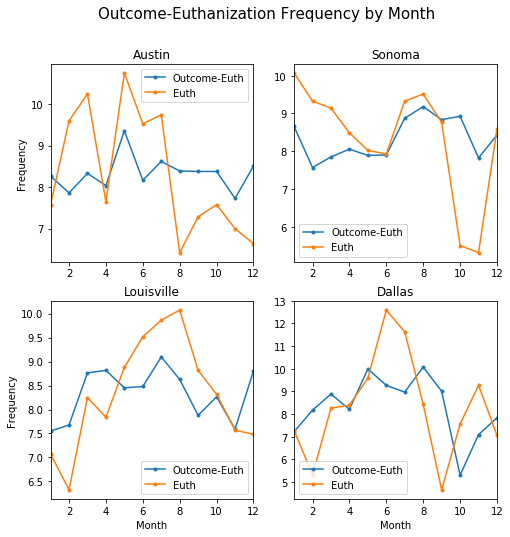

In [118]:
plt.subplot(2,2,1)
plt.plot(austin_no['index'],austin_no['Frequency'], marker = '.', label = 'Outcome-Euth')
plt.plot(austin_euth['index'],austin_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Austin')
plt.ylabel('Frequency')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,2)
plt.plot(sonoma_no['index'],sonoma_no['Frequency'], marker = '.', label = 'Outcome-Euth')
plt.plot(sonoma_euth['index'],sonoma_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Sonoma')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,3)
plt.plot(louis_no['index'],louis_no['Frequency'], marker = '.', label = 'Outcome-Euth')
plt.plot(louis_euth['index'],louis_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,4)
plt.plot(dallas_no['index'],dallas_no['Frequency'], marker = '.', label = 'Outcome-Euth')
plt.plot(dallas_euth['index'],dallas_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()
plt.suptitle('Outcome-Euthanization Frequency by Month', fontsize = 15)

Outcome-Euth chart is quite consistent without major peak and tough. It doesn't appear to match up with Euthanization frequency.

Text(0.5,0.98,'Outcome Frequency by Month')

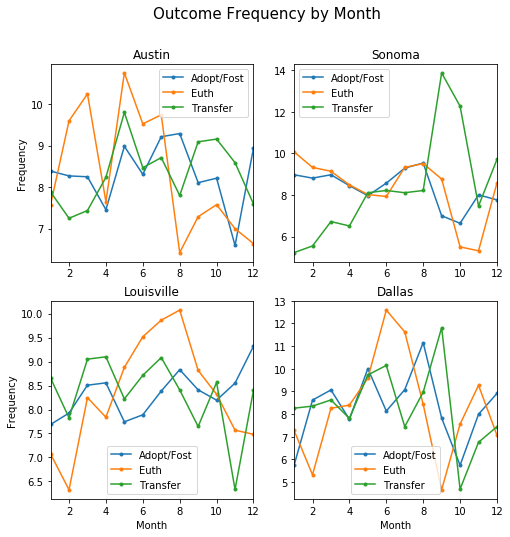

In [119]:
#display the seasonal change of euthanization and adoption
plt.subplot(2,2,1)
plt.plot(austin_adopt['index'],austin_adopt['Frequency'], marker = '.', label = 'Adopt/Fost')
plt.plot(austin_euth['index'],austin_euth['Frequency'], marker = '.', label = 'Euth')
plt.plot(austin_tr['index'],austin_tr['Frequency'], marker = '.', label = 'Transfer')
plt.title('Austin')
plt.ylabel('Frequency')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,2)
plt.plot(sonoma_adopt['index'],sonoma_adopt['Frequency'], marker = '.', label = 'Adopt/Fost')
plt.plot(sonoma_euth['index'],sonoma_euth['Frequency'], marker = '.', label = 'Euth')
plt.plot(sonoma_tr['index'],sonoma_tr['Frequency'], marker = '.', label = 'Transfer')
plt.title('Sonoma')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,3)
plt.plot(louis_adopt['index'],louis_adopt['Frequency'], marker = '.', label = 'Adopt/Fost')
plt.plot(louis_euth['index'],louis_euth['Frequency'], marker = '.', label = 'Euth')
plt.plot(louis_tr['index'],louis_tr['Frequency'], marker = '.', label = 'Transfer')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,4)
plt.plot(dallas_adopt['index'],dallas_adopt['Frequency'], marker = '.', label = 'Adopt/Fost')
plt.plot(dallas_euth['index'],dallas_euth['Frequency'], marker = '.', label = 'Euth')
plt.plot(dallas_tr['index'],dallas_tr['Frequency'], marker = '.', label = 'Transfer')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()
plt.suptitle('Outcome Frequency by Month', fontsize = 15)

The line graphs speak the heart of the project since if we want to successfully reduce euthanization rate from one location, we propose to transfer pets. We like to transfer animals in the high risk pool of euthanization to another location with low risk with low euthanization rate and high adoption rate during that time of the year. For example in Austin we observed a major dip of euthanization between Ausgust and December with relatively high adoption rate where as in Lousiville, euthanization peaks in the summer and falls in the winter. However, Louisville tends to have periodic adoption spikes every 4 months or so with the highest adoption rate in winter. Louisville is a key city since it also have the highest euthanization rate among all location.

y = 0.493x + 4.227
r-value: 0.088


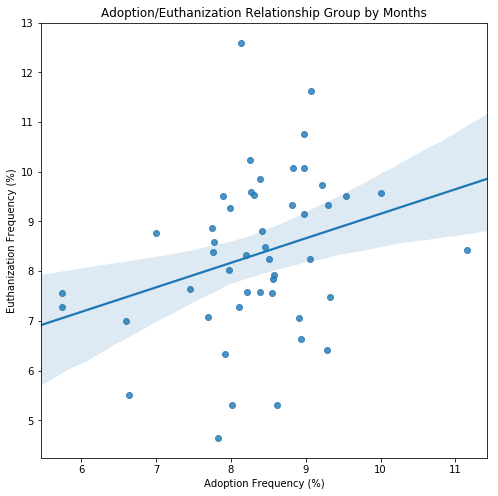

In [120]:
#mapping euthanization frequency with adoption frequency by location and month
adopt_month = austin_adopt.Frequency
adopt_month = adopt_month.append(sonoma_adopt.Frequency)
adopt_month = adopt_month.append(louis_adopt.Frequency)
adopt_month = adopt_month.append(dallas_adopt.Frequency)

euth_month = austin_euth.Frequency
euth_month = euth_month.append(sonoma_euth.Frequency)
euth_month = euth_month.append(louis_euth.Frequency)
euth_month = euth_month.append(dallas_euth.Frequency)

tr_month = austin_tr.Frequency
tr_month = tr_month.append(sonoma_tr.Frequency)
tr_month = tr_month.append(louis_tr.Frequency)
tr_month = tr_month.append(dallas_tr.Frequency)


#plot regression plot of the relationship between euthanization and adoption by month
sns.regplot(x = adopt_month, y = euth_month)
plt.xlabel('Adoption Frequency (%)')
plt.ylabel('Euthanization Frequency (%)')
plt.title('Adoption/Euthanization Relationship Group by Months')

slope, intercept, r_value, p_value, std_err = stats.linregress(x = adopt_month, y = euth_month)
print('y = ' + str(round(slope, 3)) + 'x + ' + str(round(intercept, 3)))
print('r-value:', round(r_value**2, 3))

By both linear regression and line plot, weak correlation between euthanization and adoption frequency with a r square value of 0.088. Even if r square in this case is statistically significant, it's surprising to see that euthanization is positively correlated to adoption frequency. Logically, it should be that if adoption rate increase, euthanization decrease. It's possible that the two does not correlate and other factors are involved in the decision to euthanize or euthanization is dependent on other factors. I attempt to investgate this time dependent euthanization/adoption relationship discriminated by location.

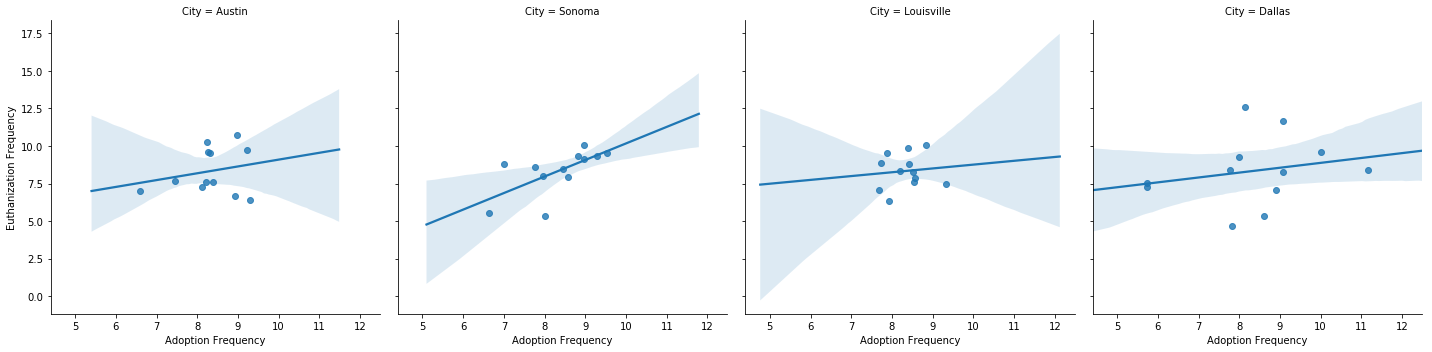

In [121]:
#ploting the regression discriminated by location
cities = pd.Series(12*['Austin'] + 12*['Sonoma'] + 12*['Louisville'] + 12*['Dallas']).rename('City')
outcome_month = pd.concat([adopt_month.rename('Adoption Frequency').reset_index(), 
                           euth_month.rename('Euthanization Frequency').reset_index(),
                           tr_month.rename('Transfer Frequency').reset_index(), 
                           cities], axis = 1)

sns.lmplot(col = 'City', x = 'Adoption Frequency', y = 'Euthanization Frequency', data = outcome_month)

In [122]:
#create a dataframe of the statistical information of the aboved linear regression
stat_table(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Adoption Frequency', 'Euthanization Frequency')

,regression,r square,p_value
Location,,,
Austin,y = 0.455x + 4.545,0.051,0.478
Sonoma,y = 1.101x + -0.844,0.427,0.021
Louisville,y = 0.254x + 6.215,0.011,0.744
Dallas,y = 0.325x + 5.628,0.049,0.491


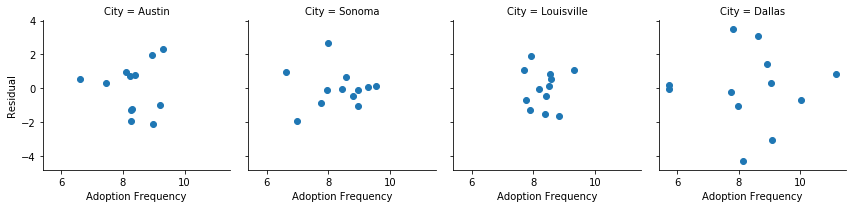

In [123]:
# residual plot of the regression lines
residual = []
for i in range(12):
    y = 0.455*outcome_month['Adoption Frequency'][i] + 4.545
    residual.append(y-outcome_month['Euthanization Frequency'][i])

for i in range(12,24):
    y = 1.101*outcome_month['Adoption Frequency'][i] - 0.844
    residual.append(y-outcome_month['Euthanization Frequency'][i])
    
for i in range(24,36):
    y = 0.254*outcome_month['Adoption Frequency'][i] + 6.215
    residual.append(y-outcome_month['Euthanization Frequency'][i])
    
for i in range(36,48):
    y = 0.325*outcome_month['Adoption Frequency'][i] + 5.628
    residual.append(y-outcome_month['Euthanization Frequency'][i])

residual = pd.Series(residual).rename('Residual')
outcome_month = pd.concat([outcome_month, residual], axis = 1)

g = sns.FacetGrid(outcome_month, col="City")
g = g.map(plt.scatter, 'Adoption Frequency', 'Residual')

The residual plot shows random points without any pattern. However besides Sonoma, none of them have good correlation values where there establish a definite correlation between euthanization and adoption. In particular, the p-value indicates the insignificance of the model. I postulate that there might be a time delay between adoption and euthanization where high adoption corresponds to low euthanization rate after the event.

In [124]:
#function to find the best delay time of euthanization rate by adoption rate using r_value as a indicator
#also assume as adoption rate goes up euthanization rate decreases
month_delay = []
def delay(dataframe, ind, Location, x_name, y_name, delay_time):
    global month_delay
    for n in range(len(Location)):
        low_r = 0
        temp = list(dataframe[y_name][ind*n: ind*n+ind])
        #set month to 0 if conditions do not meet
        month = 0
        for i in range(delay_time):
            temp.append(temp.pop(0))
            slope, intercept, r_value, p_value, std_err = (stats.linregress(
            dataframe[x_name][ind*n: ind*n+ind], temp))
            if low_r > r_value:
                low_r = r_value
                month = i+1
        temp = list(dataframe[y_name][ind*n: ind*n+ind])
        for j in range(month):
            temp.append(temp.pop(0))
        month_delay += temp        
        print(Location[n] + ' euthanization delay time:', month, ' months')
delay(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Adoption Frequency', 'Euthanization Frequency', 4)

Austin euthanization delay time: 4  months
Sonoma euthanization delay time: 3  months
Louisville euthanization delay time: 2  months
Dallas euthanization delay time: 4  months


In [125]:
#add month delay column to the dataframe
month_delay = pd.Series(month_delay).rename('Month_Delay')
outcome_month = pd.concat([outcome_month, month_delay], axis = 1)

Text(0.5,0.98,'Euth and Adoption/Foster Frequency (Month Delay)')

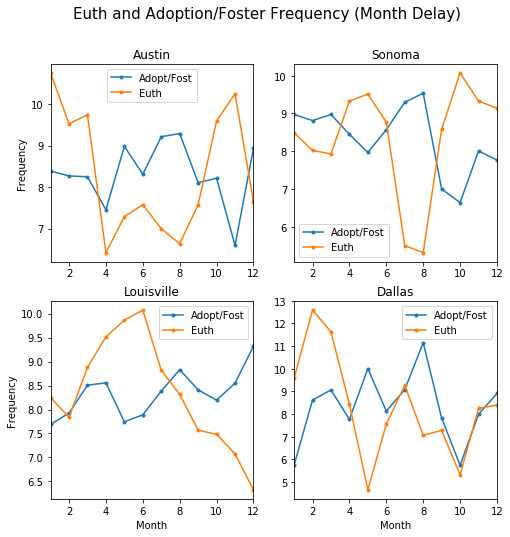

In [126]:
#visually inspect the delay euthanization rate overlapping adoption rate by month
plt.subplot(2,2,1)
plt.plot(range(1,13),outcome_month['Adoption Frequency'][:12], marker = '.', label = 'Adopt/Fost')
plt.plot(range(1,13),outcome_month['Month_Delay'][:12], marker = '.', label = 'Euth')
plt.title('Austin')
plt.ylabel('Frequency')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(1,13),outcome_month['Adoption Frequency'][12:24], marker = '.', label = 'Adopt/Fost')
plt.plot(range(1,13),outcome_month['Month_Delay'][12:24], marker = '.', label = 'Euth')
plt.title('Sonoma')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(1,13),outcome_month['Adoption Frequency'][24:36], marker = '.', label = 'Adopt/Fost')
plt.plot(range(1,13),outcome_month['Month_Delay'][24:36], marker = '.', label = 'Euth')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(1,13),outcome_month['Adoption Frequency'][36:], marker = '.', label = 'Adopt/Fost')
plt.plot(range(1,13),outcome_month['Month_Delay'][36:], marker = '.', label = 'Euth')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()
plt.suptitle('Euth and Adoption/Foster Frequency (Month Delay)', fontsize = 15)

The resultant euthanization/adoption line plot with appropriate time delay. For the most part, high adoption correlates to low euthanization generally. Dalla's data seems inconsistent and it could be due to limited data. Sonoma and Louisville improved signifantly visually where peak to trough nearly always line up. 

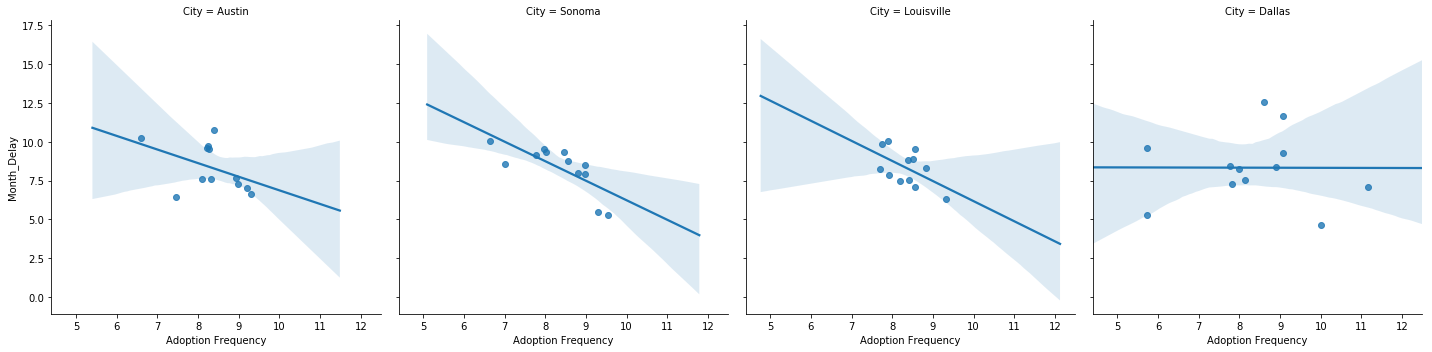

In [127]:
#regression plot of the resulting adoption rate by the delayed euthanization rate 
sns.lmplot(col = 'City', x = 'Adoption Frequency', y = 'Month_Delay', data = outcome_month)

In [128]:
#formulate a table with statistical information of the above regression plot
stat_table(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Adoption Frequency', 'Month_Delay')

,regression,r square,p_value
Location,,,
Austin,y = -0.876x + 15.634,0.191,0.155
Sonoma,y = -1.257x + 18.812,0.557,0.005
Louisville,y = -1.294x + 19.116,0.289,0.071
Dallas,y = -0.005x + 8.379,0.000,0.991


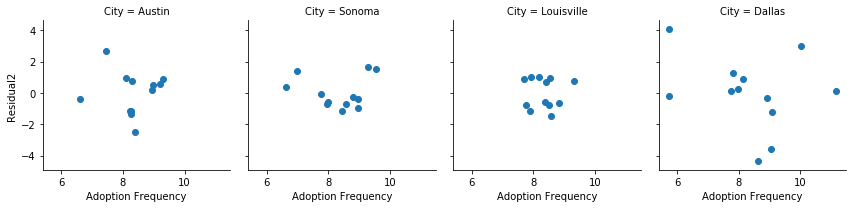

In [129]:
#residual plot of the above regression
residual = []
for i in range(12):
    y = -0.876*outcome_month['Adoption Frequency'][i] + 15.634
    residual.append(y-outcome_month['Month_Delay'][i])

for i in range(12,24):
    y = -1.257*outcome_month['Adoption Frequency'][i] + 18.812
    residual.append(y-outcome_month['Month_Delay'][i])
    
for i in range(24,36):
    y = -1.294*outcome_month['Adoption Frequency'][i] + 19.116
    residual.append(y-outcome_month['Month_Delay'][i])
    
for i in range(36,48):
    y = -0.413*outcome_month['Adoption Frequency'][i] + 11.778
    residual.append(y-outcome_month['Month_Delay'][i])

residual = pd.Series(residual).rename('Residual2')
outcome_month = pd.concat([outcome_month, residual], axis = 1)

g = sns.FacetGrid(outcome_month, col="City")
g = g.map(plt.scatter, 'Adoption Frequency', 'Residual2')

The residual plot is random. r_square improve dramatically for all the plots. Sonoma have a reasonble improvement in r_square and now up to 0.55 whereas Louisville also improve dramatically to 0.289 whereas previously it was 0.11. However, the p-value still does not indicate significance in the model and that for most locations, changes in adoption does not change the response of euthanization. This indicates there are other more significant factors or combination factors that attributes to euthanization rates for Austin, Dallas and Louisville whereas for Sonoma, adoption and euthanization rates are correlated directly. In other words, adoption and euthanization are dependent in Sonoma, where in the other locations, adoption rates do not necessary induce a response from euthanization with the possibly of transfer rates and RTO contributing more to euthanization rates.

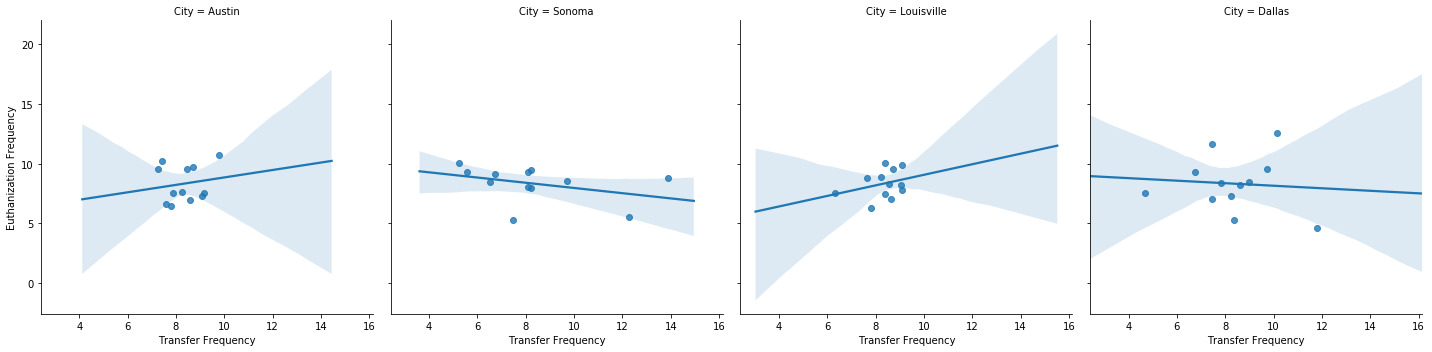

In [130]:
#ploting the regression discriminated by location
sns.lmplot(col = 'City', x = 'Transfer Frequency', y = 'Euthanization Frequency', data = outcome_month)

In [131]:
stat_table(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Transfer Frequency', 'Euthanization Frequency')

,regression,r square,p_value
Location,,,
Austin,y = 0.312x + 5.735,0.025,0.621
Sonoma,y = -0.218x + 10.154,0.140,0.231
Louisville,y = 0.443x + 4.646,0.091,0.341
Dallas,y = -0.106x + 9.216,0.007,0.797


No significance can be drawn between transfer Frequency and Euthanization frequency

In [132]:
month_delay = []
delay(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Transfer Frequency', 'Euthanization Frequency', 4)

Austin euthanization delay time: 3  months
Sonoma euthanization delay time: 1  months
Louisville euthanization delay time: 0  months
Dallas euthanization delay time: 3  months


In [133]:
month_delay = pd.Series(month_delay).rename('Month_Delay2')
outcome_month = pd.concat([outcome_month, month_delay], axis = 1)

Text(0.5,0.98,'Euth and Transfer Frequency (Month Delay)')

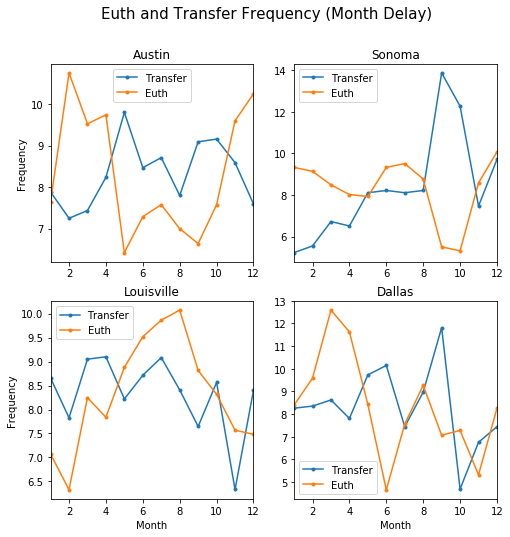

In [134]:
plt.subplot(2,2,1)
plt.plot(range(1,13),outcome_month['Transfer Frequency'][:12], marker = '.', label = 'Transfer')
plt.plot(range(1,13),outcome_month['Month_Delay2'][:12], marker = '.', label = 'Euth')
plt.title('Austin')
plt.ylabel('Frequency')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(1,13),outcome_month['Transfer Frequency'][12:24], marker = '.', label = 'Transfer')
plt.plot(range(1,13),outcome_month['Month_Delay2'][12:24], marker = '.', label = 'Euth')
plt.title('Sonoma')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(1,13),outcome_month['Transfer Frequency'][24:36], marker = '.', label = 'Transfer')
plt.plot(range(1,13),outcome_month['Month_Delay2'][24:36], marker = '.', label = 'Euth')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(1,13),outcome_month['Transfer Frequency'][36:], marker = '.', label = 'Transfer')
plt.plot(range(1,13),outcome_month['Month_Delay2'][36:], marker = '.', label = 'Euth')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()
plt.suptitle('Euth and Transfer Frequency (Month Delay)', fontsize = 15)

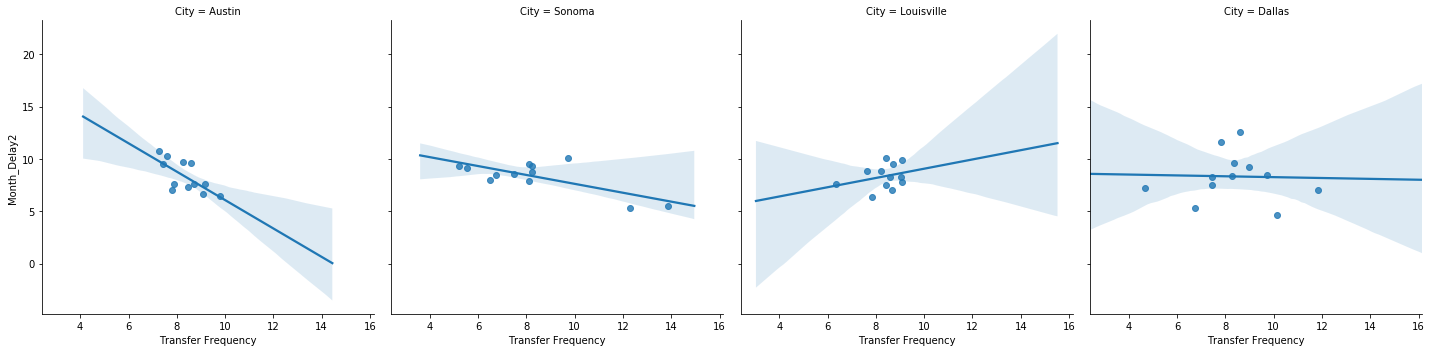

In [135]:
sns.lmplot(col = 'City', x = 'Transfer Frequency', y = 'Month_Delay2', data = outcome_month)

In [136]:
stat_table(outcome_month, 12, ['Austin','Sonoma', 'Louisville', 'Dallas'], 'Transfer Frequency', 'Month_Delay2')

,regression,r square,p_value
Location,,,
Austin,y = -1.357x + 19.644,0.481,0.012
Sonoma,y = -0.425x + 11.876,0.529,0.007
Louisville,y = 0.443x + 4.646,0.091,0.341
Dallas,y = -0.041x + 8.677,0.001,0.920


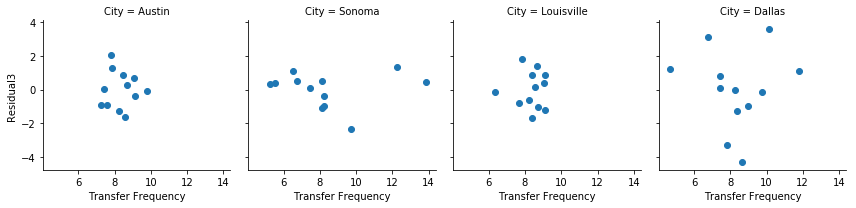

In [137]:
residual = []
for i in range(12):
    y = -1.357*outcome_month['Transfer Frequency'][i] + 19.644
    residual.append(y-outcome_month['Month_Delay2'][i])

for i in range(12,24):
    y =  -0.425*outcome_month['Transfer Frequency'][i] + 11.876
    residual.append(y-outcome_month['Month_Delay2'][i])
    
for i in range(24,36):
    y = 0.443*outcome_month['Transfer Frequency'][i] + 4.646
    residual.append(y-outcome_month['Month_Delay2'][i])
    
for i in range(36,48):
    y = -0.041*outcome_month['Transfer Frequency'][i] + 8.677
    residual.append(y-outcome_month['Month_Delay2'][i])

residual = pd.Series(residual).rename('Residual3')
outcome_month = pd.concat([outcome_month, residual], axis = 1)

g = sns.FacetGrid(outcome_month, col="City")
g = g.map(plt.scatter, 'Transfer Frequency', 'Residual3')

Austin's euthanization rate depends on transfer rate with a delay time of 3 months. Sonoma also proves the significance of transfer rate. The other locations do not depend on transfer rate or at least is not strongly dependent on transfer rate. This time series exercise shows the time dependency of euthanization rates, transfer rates and adoption rates. However, only Austin and Sonoma show that euthanization depends on adoption and transfer rates with some sort of delay factor.

In [138]:
sonoma_in = (merge_data[merge_data['Location'] == 'Sonoma']
                  [merge_data['Intake_Date'] < '2019']
                  [merge_data['Intake_Date'] > '2014']['Intake_month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

louis_in = (merge_data[merge_data['Location'] == 'Louisville']
                  [merge_data['Intake_Date'] < '2018']
                 [merge_data['Intake_Date'] > '2005']['Intake_month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

dallas_in = (merge_data[merge_data['Location'] == 'Dallas']
                  [merge_data['Intake_Date'] < '2017-10']
                  [merge_data['Intake_Date'] > '2016-09']['Intake_month']
                  .value_counts(normalize = True)
                  .mul(100)
                  .rename('Frequency')
                 .reset_index()
                 .sort_values('index'))

C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\ipykern

Text(0.5,0.98,'Intake Frequency and Euthanization Frequency Relationship')

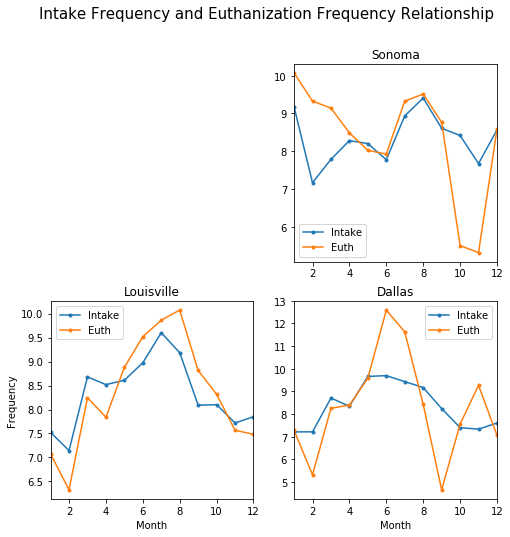

In [139]:
plt.subplot(2,2,2)
plt.plot(sonoma_in['index'],sonoma_in['Frequency'], marker = '.', label = 'Intake')
plt.plot(sonoma_euth['index'],sonoma_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Sonoma')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,3)
plt.plot(louis_in['index'],louis_in['Frequency'], marker = '.', label = 'Intake')
plt.plot(louis_euth['index'],louis_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Louisville')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()

plt.subplot(2,2,4)
plt.plot(dallas_in['index'],dallas_in['Frequency'], marker = '.', label = 'Intake')
plt.plot(dallas_euth['index'],dallas_euth['Frequency'], marker = '.', label = 'Euth')
plt.title('Dallas')
plt.xlabel('Month')
plt.xlim((1,12))
plt.legend()
plt.suptitle('Intake Frequency and Euthanization Frequency Relationship', fontsize = 15)

In [140]:
intake = pd.Series(12*[0])
intake = intake.append(sonoma_in.Frequency)
intake = intake.append(louis_in.Frequency)
intake = intake.append(dallas_in.Frequency)
intake = intake.rename('Intake')
outcome_month = pd.concat([outcome_month, intake.reset_index()], axis = 1)

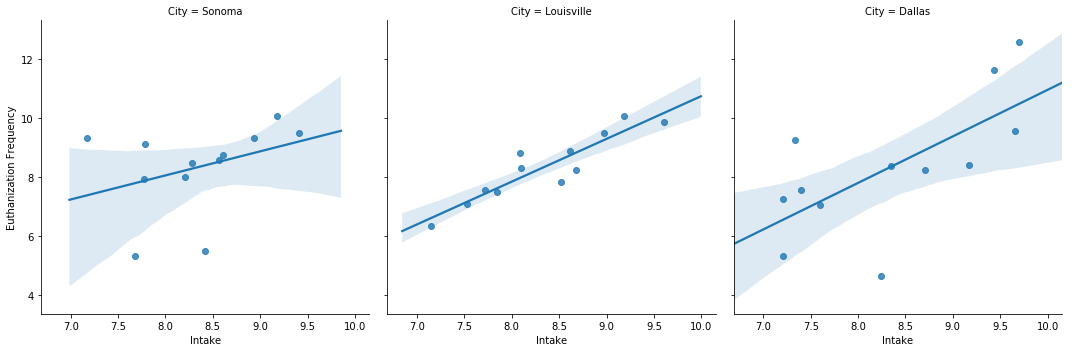

In [141]:
sns.lmplot(col = 'City', x = 'Intake', y = 'Euthanization Frequency', 
           data = outcome_month[outcome_month['City'] != 'Austin'])

In [142]:
stat_table(outcome_month.loc[12:], 12, ['Sonoma', 'Louisville', 'Dallas'], 'Intake', 'Euthanization Frequency')

,regression,r square,p_value
Location,,,
Sonoma,y = 0.818x + 1.517,0.130,0.250
Louisville,y = 1.453x + -3.775,0.842,0.000
Dallas,y = 1.581x + -4.842,0.461,0.015


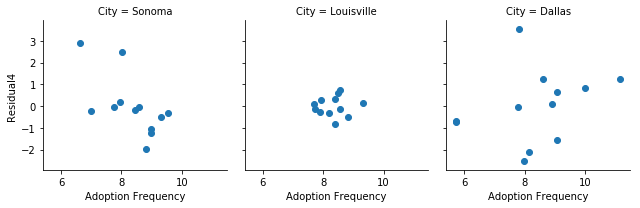

In [143]:
residual = 12*[0]

for i in range(12,24):
    y =   0.818*outcome_month['Intake'][i] + 1.517
    residual.append(y-outcome_month['Euthanization Frequency'][i])
    
for i in range(24,36):
    y = 1.453*outcome_month['Intake'][i]  - 3.775
    residual.append(y-outcome_month['Euthanization Frequency'][i])
    
for i in range(36,48):
    y =  1.581*outcome_month['Intake'][i] - 4.842
    residual.append(y-outcome_month['Euthanization Frequency'][i])

residual = pd.Series(residual).rename('Residual4')
outcome_month = pd.concat([outcome_month, residual], axis = 1)

g = sns.FacetGrid(outcome_month.loc[12:], col="City")
g = g.map(plt.scatter, 'Adoption Frequency', 'Residual4')

Both Louisville and Dallas have strong dependency between euthanization rate and intake rate with no delay time. Positive slope suggest that as intake rate increases for the month, euthanization also increase. This indicates that possibly some dogs are immediately euthanize when they are taken into the shelter or that space at the shelter plays a vital role into the survival of dogs at the shelter for Dallas and Louisville.

# Machine Learning
Because the datasets collect initially were highly chaotic and even after clean there seems to be some features considered important to be missing, I will have to separate the dataset by location and run machine learning algorithms through all of them. Also I will take out features like the outcome year to avoid adding time series factor and cannot provide future outcome of a dog

In [240]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import Sequential
from keras.layers import BatchNormalization, Dropout, Dense, Activation
from keras import regularizers

In [145]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167154 entries, 4 to 298443
Data columns (total 17 columns):
Breed               167154 non-null object
Color               167154 non-null object
Intake_Condition    35183 non-null object
Intake_Date         167154 non-null object
Intake_Type         112088 non-null object
Location            167154 non-null object
Outcome_Date        167154 non-null object
Outcome_Type        167153 non-null object
Sex                 141110 non-null object
Neutered/Spay       167154 non-null object
Pure/Mix            167154 non-null object
Pattern             167154 non-null object
Age                 116307 non-null float64
Outcome_Month       166977 non-null float64
Outcome_Year        166977 non-null float64
Intake_month        112088 non-null float64
Count               167154 non-null int64
dtypes: float64(4), int64(1), object(12)
memory usage: 28.0+ MB


In [146]:
#remove other from outcome because those dogs at shelter indicates they went missing or ran away. 
#Since missing and running away are randomized factors, we like to eliminate it
merge_data = (merge_data[merge_data.Outcome_Type != 'Other']
              .drop(columns = ['Count', 'Outcome_Year', 'Pattern', 
                               'Intake_Date', 'Outcome_Date', 
                               'Outcome_Year','Color']))

#convert outcome_month and intake_month as string
merge_data['Outcome_Month'] = merge_data['Outcome_Month'].astype(str)
merge_data['Intake_month'] = merge_data['Intake_month'].astype(str)

In [147]:
df_louis = merge_data[merge_data.Location == 'Louisville']
df_dalla = merge_data[merge_data.Location == 'Dallas']
df_aust = merge_data[merge_data.Location == 'Austin']
df_sonoma = merge_data[merge_data.Location == 'Sonoma']

In [148]:
df_louis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73710 entries, 96446 to 247281
Data columns (total 11 columns):
Breed               73710 non-null object
Intake_Condition    0 non-null object
Intake_Type         73710 non-null object
Location            73710 non-null object
Outcome_Type        73709 non-null object
Sex                 73710 non-null object
Neutered/Spay       73710 non-null object
Pure/Mix            73710 non-null object
Age                 50957 non-null float64
Outcome_Month       73710 non-null object
Intake_month        73710 non-null object
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [149]:
#fill na with average for age and drop unused columns
mean = np.mean(merge_data['Age'])
df_louis = df_louis.fillna(value = {'Age': mean})
df_louis = df_louis.drop(columns = ['Intake_Condition', 'Location'])
df_louis = df_louis.dropna()

In [150]:
#categorize age for bernoulli naive bayes
def categorize(data):
    low = data.quantile(.25)
    high = data.quantile(.75)
    output = []
    for value in data:
        if value <= low:
            output.append('Low')
        elif value >= high:
            output.append('High')
        else:
            output.append('Medium')
    return output
# create temp dataframe to encode
temp1 = categorize(df_louis.Age)
cat_df_louis = df_louis.drop(columns = ['Age', 'Outcome_Type'])
cat_df_louis['Age'] = temp1

#initialize onehotencoder and scaler
ohe = OneHotEncoder(sparse = False)

#transform and concatenate data
cat_df_louis = ohe.fit_transform(cat_df_louis)

#assigning target and features
y = df_louis.Outcome_Type
X = cat_df_louis

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size = .3)

In [151]:
#run bernullli naive bayes with random search cross validation with hyperparametering tuning
NB = BernoulliNB()
param_grid = {'alpha': np.logspace(-3,0, num = 50)}
NB_cv = RandomizedSearchCV(NB, param_grid, cv = 3, verbose = 2, n_iter = 10, scoring = 'accuracy', random_state = 12)
NB_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] alpha=0.0517947467923121 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... alpha=0.0517947467923121, total=   0.2s
[CV] alpha=0.0517947467923121 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ......................... alpha=0.0517947467923121, total=   0.3s
[CV] alpha=0.0517947467923121 ........................................
[CV] ......................... alpha=0.0517947467923121, total=   0.2s
[CV] alpha=0.655128556859551 .........................................
[CV] .......................... alpha=0.655128556859551, total=   0.2s
[CV] alpha=0.655128556859551 .........................................
[CV] .......................... alpha=0.655128556859551, total=   0.2s
[CV] alpha=0.655128556859551 .........................................
[CV] .......................... alpha=0.655128556859551, total=   0.2s
[CV] alpha=0.0026826957952797246 .....................................
[CV] ...................... alpha=0.0026826957952797246, total=   0.2s
[CV] alpha=0.0026826957952797246 .....................................
[CV] ...................... alpha=0.0026826957952797246, total=   0.2s
[CV] alpha=0.0026826957952797246 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   13.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'alpha': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0.03907,...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
          pre_dispatch='2*n_jobs', random_state=12, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [152]:
print('Best alpha:', NB_cv.best_params_)

Best alpha: {'alpha': 0.0026826957952797246}


In [153]:
print('Best Score:', NB_cv.best_score_)

Best Score: 0.6184975579502286


In [154]:
print('Performance of naive bayes on test:', NB_cv.score(X_test, y_test))

Performance of naive bayes on test: 0.617012617012617


In [155]:
y_pred = NB_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3731,    1,  138,  877,   49],
       [  26,  252,  248,   29,   22],
       [ 817,   23, 7622,  333,  259],
       [1112,    6, 1092, 1705,  118],
       [1313,    6, 1383,  617,  334]], dtype=int64)

In [156]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Adoption/Foster       0.53      0.78      0.63      4796
           Died       0.88      0.44      0.58       577
           Euth       0.73      0.84      0.78      9054
            Rto       0.48      0.42      0.45      4033
       Transfer       0.43      0.09      0.15      3653

      micro avg       0.62      0.62      0.62     22113
      macro avg       0.61      0.51      0.52     22113
   weighted avg       0.59      0.62      0.58     22113



In [212]:
# create temp dataframe to encode and scale
temp1 = df_louis.Age.values.reshape(-1,1)
temp2 = df_louis.drop(columns=['Age', 'Outcome_Type'])

#initialize onehotencoder and scaler
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()

#transform and concatenate data
temp1 = scaler.fit_transform(temp1)
temp2 = ohe.fit_transform(temp2)

#assigning target and features
y = df_louis.Outcome_Type
X = np.concatenate((temp1,temp2), axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size = .3)

In [158]:
#run logistic regression with random search cross validation and hypertuning
lm = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr')
param_grid = {'C': np.logspace(-3, 0, num = 50)}
lm_cv = RandomizedSearchCV(lm, param_grid, cv = 3, verbose = 2, n_iter = 10, scoring = 'accuracy', random_state = 12)
lm_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.0517947467923121 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.0517947467923121, total=   2.7s
[CV] C=0.0517947467923121 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ............................. C=0.0517947467923121, total=   2.8s
[CV] C=0.0517947467923121 ............................................
[CV] ............................. C=0.0517947467923121, total=   2.9s
[CV] C=0.655128556859551 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] .............................. C=0.655128556859551, total=   4.2s
[CV] C=0.655128556859551 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] .............................. C=0.655128556859551, total=   4.3s
[CV] C=0.655128556859551 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] .............................. C=0.655128556859551, total=   3.9s
[CV] C=0.0026826957952797246 .........................................
[CV] .......................... C=0.0026826957952797246, total=   1.0s
[CV] C=0.0026826957952797246 .........................................
[CV] .......................... C=0.0026826957952797246, total=   1.0s
[CV] C=0.0026826957952797246 .........................................
[CV] .......................... C=0.0026826957952797246, total=   1.0s
[CV] C=0.32374575428176433 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.32374575428176433, total=   3.6s
[CV] C=0.32374575428176433 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.32374575428176433, total=   3.7s
[CV] C=0.32374575428176433 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.32374575428176433, total=   4.0s
[CV] C=0.15998587196060574 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.15998587196060574, total=   3.6s
[CV] C=0.15998587196060574 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.15998587196060574, total=   3.8s
[CV] C=0.15998587196060574 ...........................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................ C=0.15998587196060574, total=   3.7s
[CV] C=0.05963623316594643 ...........................................
[CV] ............................ C=0.05963623316594643, total=   3.0s
[CV] C=0.05963623316594643 ...........................................
[CV] ............................ C=0.05963623316594643, total=   3.0s
[CV] C=0.05963623316594643 ...........................................
[CV] ............................ C=0.05963623316594643, total=   3.1s
[CV] C=0.019306977288832496 ..........................................
[CV] ........................... C=0.019306977288832496, total=   2.1s
[CV] C=0.019306977288832496 ..........................................
[CV] ........................... C=0.019306977288832496, total=   2.2s
[CV] C=0.019306977288832496 ..........................................
[CV] ........................... C=0.019306977288832496, total=   2.1s
[CV] C=0.868511373751352 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Loca

[CV] .............................. C=0.868511373751352, total=   7.3s
[CV] C=0.868511373751352 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Loca

[CV] .............................. C=0.868511373751352, total=   8.7s
[CV] C=0.868511373751352 .............................................


C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] .............................. C=0.868511373751352, total=   4.2s
[CV] C=0.014563484775012436 ..........................................
[CV] ........................... C=0.014563484775012436, total=   1.8s
[CV] C=0.014563484775012436 ..........................................
[CV] ........................... C=0.014563484775012436, total=   1.8s
[CV] C=0.014563484775012436 ..........................................
[CV] ........................... C=0.014563484775012436, total=   1.6s
[CV] C=0.0030888435964774815 .........................................
[CV] .......................... C=0.0030888435964774815, total=   0.9s
[CV] C=0.0030888435964774815 .........................................
[CV] .......................... C=0.0030888435964774815, total=   1.0s
[CV] C=0.0030888435964774815 .........................................
[CV] .......................... C=0.0030888435964774815, total=   0.9s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sadmin\AppData\Local\Enthought\Canopy\edm\envs\python3.6\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0.03907, 0.0...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
          pre_dispatch='2*n_jobs', random_state=12, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [159]:
print('Best C:', lm_cv.best_params_)

Best C: {'C': 0.655128556859551}


In [160]:
print('Best Score:', lm_cv.best_score_)

Best Score: 0.6376075664780215


In [161]:
print('Performance of naive bayes on test:', lm_cv.score(X_test,y_test))

Performance of naive bayes on test: 0.6335639668973002


In [162]:
y_pred = lm_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3986,    0,  234,  537,   39],
       [  28,  238,  269,   19,   23],
       [ 602,    0, 8110,  250,   92],
       [1268,    1, 1183, 1484,   97],
       [1339,    0, 1655,  467,  192]], dtype=int64)

In [163]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Adoption/Foster       0.55      0.83      0.66      4796
           Died       1.00      0.41      0.58       577
           Euth       0.71      0.90      0.79      9054
            Rto       0.54      0.37      0.44      4033
       Transfer       0.43      0.05      0.09      3653

      micro avg       0.63      0.63      0.63     22113
      macro avg       0.65      0.51      0.51     22113
   weighted avg       0.61      0.63      0.58     22113



In [164]:
#run kNN classifier 
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,40)}
knn_cv = RandomizedSearchCV(knn, param_grid, cv = 3, verbose = 2, random_state =12, n_iter = 10, scoring = 'accuracy')
knn_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neighbors=20 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... n_neighbors=20, total= 1.3min
[CV] n_neighbors=20 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV] ................................... n_neighbors=20, total= 1.1min
[CV] n_neighbors=20 ..................................................
[CV] ................................... n_neighbors=20, total= 1.2min
[CV] n_neighbors=24 ..................................................


KeyboardInterrupt: 

In [ ]:
print('Best k neighbors:', knn_cv.best_params_)

In [ ]:
print('Best Score:', knn_cv.best_score_)

In [ ]:
print('Performance of k nearest neighbor:', knn_cv.score(X_test, y_test))

In [ ]:
y_pred = knn_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#run random Forest with Grid Search with hyperparameter tuning
RF = RandomForestClassifier(random_state = 10)
param_grid = {'n_estimators': [20, 50, 100, 200, 400, 600, 800, 1000]}
RF_cv = GridSearchCV(RF, param_grid, cv = 3, verbose = 2, scoring = 'accuracy')
RF_cv.fit(X_train, y_train)

In [ ]:
print('Best # of trees in a forest:', RF_cv.best_params_)

In [ ]:
print('Best Score:', RF_cv.best_score_)

In [ ]:
print('Performance of random forest: ', RF_cv.score(X_test,y_test))

In [ ]:
y_pred = RF_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [213]:
#encode the y_train 
y_train_deep = OneHotEncoder().fit_transform(y_train.values.reshape(-1,1))

#define X_train shape
in_dim = X_train.shape[1]

In [214]:
DNN = Sequential()

DNN.add(Dense(512, input_shape = (in_dim,)))
DNN.add(Dropout(0.4))
DNN.add(Activation('relu'))

DNN.add(Dense(256))
DNN.add(BatchNormalization())
DNN.add(Activation('relu'))

DNN.add(Dense(128))
DNN.add(Dropout(0.4))
DNN.add(Activation('relu'))

DNN.add(Dense(64))
DNN.add(BatchNormalization())
DNN.add(Activation('relu'))

DNN.add(Dense(32))
DNN.add(Dropout(0.4))
DNN.add(Activation('relu'))
    
DNN.add(Dense(16))
DNN.add(BatchNormalization())
DNN.add(Activation('relu'))

DNN.add(Dense(5))
DNN.add(Activation('softmax'))
    
DNN.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = DNN.fit(X_train, y_train_deep, validation_split = 0.3, batch_size = 256, epochs = 50, verbose = 2)

Train on 36117 samples, validate on 15479 samples
Epoch 1/50
 - 5s - loss: 1.3336 - acc: 0.4869 - val_loss: 1.0813 - val_acc: 0.6156
Epoch 2/50
 - 3s - loss: 1.0452 - acc: 0.6172 - val_loss: 0.9667 - val_acc: 0.6361
Epoch 3/50
 - 3s - loss: 0.9902 - acc: 0.6309 - val_loss: 0.9143 - val_acc: 0.6526
Epoch 4/50
 - 3s - loss: 0.9442 - acc: 0.6478 - val_loss: 0.8929 - val_acc: 0.6623
Epoch 5/50
 - 3s - loss: 0.9214 - acc: 0.6555 - val_loss: 0.8782 - val_acc: 0.6657
Epoch 6/50
 - 3s - loss: 0.9144 - acc: 0.6588 - val_loss: 0.8790 - val_acc: 0.6654
Epoch 7/50
 - 3s - loss: 0.9005 - acc: 0.6643 - val_loss: 0.8724 - val_acc: 0.6644
Epoch 8/50
 - 3s - loss: 0.8948 - acc: 0.6645 - val_loss: 0.8763 - val_acc: 0.6657
Epoch 9/50
 - 3s - loss: 0.8873 - acc: 0.6661 - val_loss: 0.8708 - val_acc: 0.6670
Epoch 10/50
 - 3s - loss: 0.8826 - acc: 0.6684 - val_loss: 0.8655 - val_acc: 0.6707
Epoch 11/50
 - 3s - loss: 0.8790 - acc: 0.6701 - val_loss: 0.8642 - val_acc: 0.6721
Epoch 12/50
 - 3s - loss: 0.8742 - 

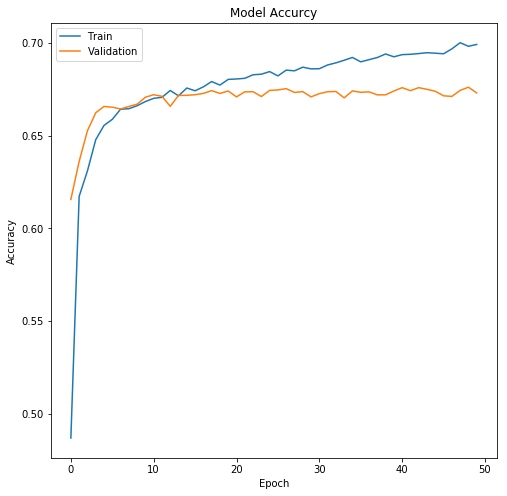

In [215]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accurcy')
plt.legend(['Train', 'Validation'])

Model seems to have high variance as train data accuracy deviates from test case. Cross validation may help to improve variance without significantly changing the architecture of the model

In [216]:
DNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 512)               30720     
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
activation_73 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
activation_74 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               32896     
__________

In [236]:
#reverse encode the y_train
check = {}
y_train = y_train.reset_index()
for ind, i in enumerate(y_train_deep):
    if len(check) != 5:
        if np.argmax(i) not in check:
            check[np.argmax(i)]= y_train.iloc[ind,1]
    else:
        break

In [206]:
#predict test case
predict = DNN.predict(X_test)

0

In [238]:
predict_str = []
for i in predict:
    ind = np.argmax(i)
    predict_str.append(check[ind])

In [243]:
print('Accuracy of Neural Network:', round(accuracy_score( y_test, predict_str), 3))

Accuracy of Neural Network: 0.676


The accuracy of the neural network aligns will within the range of the score achieved from val_acc

In [244]:
print(confusion_matrix(y_test, predict_str))

[[3845    0  190  521  240]
 [  26  259  197   51   44]
 [ 479   16 7767  422  370]
 [ 695    4  791 2343  200]
 [1250    3 1141  516  743]]


In [245]:
print(classification_report(y_test, predict_str))

                 precision    recall  f1-score   support

Adoption/Foster       0.61      0.80      0.69      4796
           Died       0.92      0.45      0.60       577
           Euth       0.77      0.86      0.81      9054
            Rto       0.61      0.58      0.59      4033
       Transfer       0.47      0.20      0.28      3653

      micro avg       0.68      0.68      0.68     22113
      macro avg       0.67      0.58      0.60     22113
   weighted avg       0.66      0.68      0.65     22113

